In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)

In [2]:
import sys
import gym
import pylab
import random
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

EPISODES = 10000

np.random.seed(123)
random.seed(456)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K

tf.set_random_seed(789)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.action_table = [0,1,-4,4]
        self.lam = 0
        self.alpha = 0.1
        self.target_state = 11

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 1
        self.actor_lr = 0.005
        self.critic_lr = 0.005

        # create model for policy network
        self.actor = self.build_actor()        
        self.critic = self.build_critic()
        self.critic2 = self.build_critic2()

        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor.h5")
            self.critic.load_weights("./save_model/cartpole_critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic
    
    def build_critic2(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic
        

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def get_maxaction(self,state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.argmax(policy)

    # update policy network every episode
    def train_model(self, state, action, reward1,reward2, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))
        target2 = np.zeros((1, self.value_size))     

        value = self.critic.predict(state)[0]
        value2 = self.critic2.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        next_value2 = self.critic2.predict(next_state)[0]
        
        reward1 = reward1 + self.lam*(reward2 - self.alpha)

        if done:
            advantages[0][action] = -1*(reward1 - value)
            target[0][0] = reward1
            target2[0][0] = 0
        else:
            advantages[0][action] = -1*(reward1 + self.discount_factor * (next_value) - value)
            target[0][0] = reward1 + self.discount_factor * next_value
            target2[0][0] = reward2 + self.discount_factor * next_value2
#             if np.where(next_state == 1.0)[1][0] == self.target_state:
#                 target2[0][0] = 0 + self.discount_factor * next_value2
#             else:
#                 target2[0][0] = np.where(next_state == 1.0)[1][0]/10 + self.discount_factor * next_value2            
            

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)
        self.critic2.fit(state,target2,epochs = 1, verbose = 0)
        
        initial_state = np.zeros((1,state_size))
        initial_state[0][0] = 1
        self.lam = min(max(0,(self.lam + 0.001*(self.critic2.predict(state)[0] - self.alpha))), 10)
        #print(self.lam)
        
        
        
    
    def get_next(self,state,action1,action2):
        #print(state)
        state_index1 = np.where(state == 1.0)[1][0]
        state_index2 = np.where(state == 1.0)[1][1] - 16
        
        
        next_state_index1 = state_index1 + self.action_table[action1]
        next_state_index2 = state_index2 + self.action_table[action2]
        
        
        next_state = np.zeros((1,self.state_size))

        if next_state_index1 > self.state_size/2-1 or next_state_index1 < 0:
            next_state_index1 = state_index1
            next_state[0][next_state_index1] = 1
        else:
            next_state[0][next_state_index1] = 1
            
        
        if next_state_index2 > self.state_size/2-1 or next_state_index2 < 0:
            next_state_index2 = state_index2
            next_state[0][16 + next_state_index2] = 1
        else:
            #print(state_index2)
            #print(next_state_index2)
            next_state[0][16 + next_state_index2] = 1
            
            
            
        if next_state_index1 == self.target_state and next_state_index2 == self.target_state:
#             reward = 0.0 - self.alpha # + (self.lam*(np.where(state == 1.0)[1][0]/10 - 0.5))  
            done = True
        else:
            done = False
#             reward = 1.0 + (self.lam*(np.where(next_state == 1.0)[1][0]/10 - self.alpha))   
        
        return next_state,done

    

def get_rewards(state1,state2):
    
    if state1 == 11 and state2 == 11:
        reward1 = 0.0
    else:
        reward1 = 1.0
        
    if state1 == 11 or state2 == 11:
        reward2 = 0
    elif state1 == state2:
        reward2 = 1.0
    else:
        reward2 = 0
    
    return reward1,reward2

def intrepret_action(action):
    action1,action2 = np.divmod(action,4)
    return action1,action2
    
    

if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = 16+16 #env.observation_space.shape[0]
    action_size = 4*4 #env.action_space.n

    # make A2C agent
    agent = A2CAgent(state_size, action_size)
    #agent = A2CAgent(state_size,action_size)
    
    scores, episodes = [], []
    
    average_penalty = 0
    total_penalty = 0
    store_penalty = np.zeros((1,EPISODES))
    
    average_lag = 0
    total_lag = 0
    store_lag = np.zeros((1,EPISODES))
    
    opt_pol_penalty = 0
    opt_pol_count = 0

    for i in range(1):
        done = False
        score = 0
        #state = env.reset()
        #state = np.reshape(state, [1, state_size])
        #rand_state = random.randint(0,15)
        #state = np.zeros((1,state_size))
        #state[0][rand_state] = 1
        #state = np.reshape(state, [1, state_size])
        
        for e in range(EPISODES):
        #state = env.reset()
            rand_state1 = random.randint(0,state_size/2-1)
            rand_state2 = random.randint(0,state_size/2-1)

            state = np.zeros((1,state_size))
            #state2 = np.zeros((1,state_size))
            
            state[0][rand_state1] = 1
            state[0][16+rand_state1] = 1
            
            #state = np.reshape(state, [1, state_size])
            for time in range(10):
            # env.render()
                action = agent.get_action(state)
                action1,action2 = intrepret_action(action)
                
                if state[0][11] == 1:
                    action1=0
                if state[0][16+11] ==1:
                    action2 = 0
                
                next_state, done = agent.get_next(state,action1,action2)
                #next_state2, done2 = agent2.get_next(state2,action2)
                
                reward1,reward2 = get_rewards(np.where(next_state == 1.0)[1][0],np.where(next_state == 1.0)[1][1] - 16)

            #reward = reward if not done else -10
                #next_state = np.reshape(next_state, [1, state_size])
                agent.train_model(state, action, reward1,reward2,next_state, done)
                #agent2.train_model(state2, action2, reward1,reward2,next_state2, done2)
                
                
                print(np.where(state == 1.0)[1][0],np.where(state == 1.0)[1][1] - 16,action1,action2,np.where(next_state == 1.0)[1][0],np.where(next_state == 1.0)[1][1] - 16)
                #print(agent1.lam,agent2.lam)
                state = next_state
                average_penalty = average_penalty + reward2
                
                average_lag = average_lag + reward1
                
                #state2 = next_state2
                if done:
                #print(state)
                    print("episode: {}/{}, score: {}"
                      .format(e, EPISODES, time))
                    print(agent.lam)
                    #print(agent2.lam)
                    break
                #if len(agent.memory) > batch_size:
                    #agent.replay(batch_size)
            total_penalty = total_penalty + average_penalty
            store_penalty[0][e] = total_penalty/(e+1)
            print(store_penalty[0][e])
            
            total_lag = total_lag + average_lag
            store_lag[0][e] = total_lag/(e+1)
            
            if e > EPISODES - 1000:
                opt_pol_count = opt_pol_count + 1
                opt_pol_penalty = opt_pol_penalty + average_penalty
            
            average_penalty = 0
            average_lag = 0
            
        
            print('*******************************')

/home/raghuram/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                400       
Total params: 1,192
Trainable params: 1,192
Non-trainable params: 0
_________________________________________________________________
14 14 3 0 14 14
14 14 1 2 15 10
15 10 3 3 15 14
15 14 2 3 11 14
11 14 0 2 11 10
11 10 0 1 11 11
episode: 0/10000, score: 5
0
1.0
*******************************
13 13 1 0 14 13
14 13 2 3 10 13
10 13 1 2 11 9
11 9 0 1 11 10
11 10 0 1 11 11
episode: 1/10000, score: 4
0
0.5
*******************************
1 1 2 3 1 5
1 5 0 2 1 1
1 1 0 2 1 1
1 1 2 0 1 1
1 1 2 0 1 1
1 1 2 2 1 1
1 1 3 1 5 2
5 2 2 3 1 6
1 6 2 1 1 7
1 7 2 3 1 11
2.0
*******************************
10 10 1 0 11 10
11 10 0 0 11 10
11 10 0 3 11 14
11 14 0 3 11 14
11 14 0 1 1

3 12 1 0 4 12
4 12 1 3 5 12
5 12 2 1 1 13
0.6136363636363636
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 0 3 6 10
6 10 2 1 2 11
2 11 2 0 2 11
2 11 0 0 2 11
2 11 3 0 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 44/10000, score: 8
[0.13293563]
0.6222222222222222
*******************************
6 6 0 3 6 10
6 10 1 0 7 10
7 10 3 2 11 6
11 6 0 0 11 6
11 6 0 2 11 2
11 2 0 1 11 3
11 3 0 3 11 7
11 7 0 2 11 3
11 3 0 3 11 7
11 7 0 0 11 7
0.6086956521739131
*******************************
5 5 0 0 5 5
5 5 0 1 5 6
5 6 1 0 6 6
6 6 3 1 10 7
10 7 1 2 11 3
11 3 0 3 11 7
11 7 0 3 11 11
episode: 46/10000, score: 6
[0.14415295]
0.6382978723404256
*******************************
0 0 0 2 0 0
0 0 0 3 0 4
0 4 0 1 0 5
0 5 3 0 4 5
4 5 1 1 5 6
5 6 0 3 5 10
5 10 3 1 9 11
9 11 1 0 10 11
10 11 3 0 14 11
14 11 0 0 14 11
0.6458333333333334
*******************************
14 14 2 3 10 14
10 14 1 3 11 14
11 14 0 1 11 15
11 15 0 1 11 15
11 15 0 1 11 15
11 15 0 3 11 15
11 15 0 2 11 11
episode: 48/10000, sco

11 11 0 0 11 11
episode: 91/10000, score: 0
[0.2580952]
0.6739130434782609
*******************************
12 12 1 1 13 13
13 13 1 2 14 9
14 9 0 1 14 10
14 10 1 1 15 11
15 11 1 0 15 11
15 11 2 0 11 11
episode: 92/10000, score: 5
[0.2613112]
0.6774193548387096
*******************************
14 14 3 1 14 15
14 15 1 1 15 15
15 15 0 3 15 15
15 15 2 0 11 15
11 15 0 3 11 15
11 15 0 3 11 15
11 15 0 2 11 11
episode: 93/10000, score: 6
[0.2647617]
0.6914893617021277
*******************************
10 10 1 3 11 14
11 14 0 1 11 15
11 15 0 2 11 11
episode: 94/10000, score: 2
[0.2656335]
0.6842105263157895
*******************************
0 0 1 1 1 1
1 1 1 1 2 2
2 2 0 1 2 3
2 3 1 1 3 4
3 4 3 0 7 4
7 4 1 1 8 5
8 5 0 3 8 9
8 9 1 3 9 13
9 13 1 1 10 14
10 14 1 1 11 15
0.6979166666666666
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 0 3 9 10
9 10 1 1 10 11
10 11 2 0 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 96/10000, score: 6
[0.27685472]
0.6907216494845361
*******************************

2 2 1 1 3 3
3 3 0 3 3 7
3 7 0 2 3 3
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 141/10000, score: 6
[0.45643792]
0.9295774647887324
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 2 6 2
6 2 1 1 7 3
7 3 0 3 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 142/10000, score: 6
[0.46313903]
0.9440559440559441
*******************************
12 12 1 1 13 13
13 13 1 3 14 13
14 13 1 1 15 14
15 14 1 1 15 15
15 15 0 2 15 11
15 11 2 0 11 11
episode: 143/10000, score: 5
[0.471023]
0.9513888888888888
*******************************
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 144/10000, score: 3
[0.47382602]
0.9586206896551724
*******************************
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 145/10000, score: 2
[0.47479928]
0.958904109589041
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 146/10000, score: 3
[0.47683185]
0.9523809523809523
*******************************
15 15 1 1 15 15
15 15 0 2

4 11 1 0 5 11
5 11 1 0 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 197/10000, score: 8
[0.59853876]
0.9949494949494949
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 198/10000, score: 1
[0.5989365]
0.9949748743718593
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 199/10000, score: 1
[0.5986711]
0.99
*******************************
11 11 0 0 11 11
episode: 200/10000, score: 0
[0.59834296]
0.9850746268656716
*******************************
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 0 0 7 11
7 11 3 0 11 11
episode: 201/10000, score: 4
[0.60023075]
0.9900990099009901
*******************************
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 202/10000, score: 2
[0.60080755]
0.9901477832512315
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 203/10000, score: 1
[0.6005942]
0.9852941176470589
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 0 1 10 11
10 11 3 0 14 11
14 11 3 0 14 11
14 11 1 0 15 11
15 11 1 0 1

9 9 1 1 10 10
10 10 1 1 11 11
episode: 257/10000, score: 1
[0.6778986]
0.9767441860465116
*******************************
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 258/10000, score: 2
[0.6787008]
0.9768339768339769
*******************************
10 10 1 1 11 11
episode: 259/10000, score: 0
[0.6786221]
0.9730769230769231
*******************************
10 10 1 1 11 11
episode: 260/10000, score: 0
[0.6785415]
0.9693486590038314
*******************************
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 261/10000, score: 3
[0.68129605]
0.9732824427480916
*******************************
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 262/10000, score: 3
[0.6840247]
0.9771863117870723
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 263/10000, score: 3
[0.68958104]
0.9848484848484849
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 264/10000, score: 2
[0.69216466]


2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 317/10000, score: 6
[0.7742879]
0.9968553459119497
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 318/10000, score: 3
[0.7795237]
1.0031347962382444
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 319/10000, score: 2
[0.7819947]
1.00625
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 320/10000, score: 4
[0.78684294]
1.0124610591900312
*******************************
11 11 0 0 11 11
episode: 321/10000, score: 0
[0.7866745]
1.0093167701863355
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 322/10000, score: 3
[0.7921378]
1.0154798761609907
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 323/10000, score: 1
[0.79288787]
1.0154320987654322
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7

14 14 1 1 15 15
15 15 2 2 11 11
episode: 379/10000, score: 2
[0.8708731]
1.013157894736842
*******************************
10 10 1 1 11 11
episode: 380/10000, score: 0
[0.8707723]
1.010498687664042
*******************************
15 15 2 2 11 11
episode: 381/10000, score: 0
[0.870679]
1.0078534031413613
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 382/10000, score: 4
[0.8761575]
1.0130548302872062
*******************************
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 383/10000, score: 2
[0.8769205]
1.0130208333333333
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 384/10000, score: 5
[0.87659204]
1.0103896103896104
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 385/10000, score: 1
[0.8763379]
1.0077720207253886
*******************************
10 10 1 1 11 11
episode: 386/10000, score: 0
[0.8762132]
1.0051679586563307
******

7 11 3 0 11 11
episode: 440/10000, score: 1
[0.9629795]
1.018140589569161
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 441/10000, score: 3
[0.968525]
1.0226244343891402
*******************************
10 10 1 1 11 11
episode: 442/10000, score: 0
[0.9684108]
1.020316027088036
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 443/10000, score: 4
[0.9735064]
1.0247747747747749
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 444/10000, score: 2
[0.9759968]
1.0269662921348315
*******************************
5 5 1 1 6 6
6 6 1 1 7 7
7 7 0 3 7 11
7 11 3 0 11 11
episode: 445/10000, score: 3
[0.97836185]
1.0291479820627802
*******************************
2 2 0 3 2 6
2 6 1 1 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 446/10000, score: 4
[0.9784641]
1.0268456375838926
*******************************
11 11 0 0 11 11
episode: 447/10000, sco

14 14 1 1 15 15
15 15 2 2 11 11
episode: 502/10000, score: 3
[1.0881581]
1.0576540755467196
*******************************
11 11 0 0 11 11
episode: 503/10000, score: 0
[1.0880525]
1.0555555555555556
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 504/10000, score: 4
[1.0931796]
1.0574257425742575
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 505/10000, score: 3
[1.0932218]
1.0553359683794465
*******************************
6 6 1 2 7 2
7 2 0 3 7 6
7 6 0 3 7 10
7 10 1 1 8 11
8 11 1 0 9 11
9 11 1 0 10 11
10 11 1 0 11 11
episode: 506/10000, score: 6
[1.0937914]
1.0532544378698225
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 507/10000, score: 3
[1.0988971]
1.0570866141732282
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 1 1 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 508/10000, score: 6
[

0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 563/10000, score: 6
[1.1474473]
1.0407801418439717
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 564/10000, score: 1
[1.1481922]
1.0407079646017698
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 565/10000, score: 1
[1.1480334]
1.03886925795053
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 566/10000, score: 4
[1.1519115]
1.0405643738977073
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 567/10000, score: 4
[1.1557418]
1.0422535211267605
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 568/10000, score: 1
[1.1564753]
1.0421792618629173
*******************************
11 11 0 0 11 11
episode: 569/10000, score: 0
[1.156369]
1.0403508771929824
*******************************
15 15 2 2 11 11
episode: 57

15 15 2 2 11 11
episode: 623/10000, score: 1
[1.1891379]
1.0112179487179487
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 624/10000, score: 1
[1.188953]
1.0096
*******************************
15 15 2 2 11 11
episode: 625/10000, score: 0
[1.1888502]
1.0079872204472844
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 626/10000, score: 1
[1.1896527]
1.0079744816586922
*******************************
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 627/10000, score: 3
[1.1904782]
1.0079617834394905
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 628/10000, score: 3
[1.1902537]
1.0063593004769475
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 629/10000, score: 1
[1.1910617]
1.0063492063492063
*******************************
15 15 2 2 11 11
episode: 630/10000, score: 0
[1.1909591]
1.0047543581616483
*******************************
15 15 2 2 11 11
episode: 631/

2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 687/10000, score: 5
[1.2407981]
0.9898255813953488
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 688/10000, score: 2
[1.243439]
0.9912917271407837
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 689/10000, score: 1
[1.2432255]
0.9898550724637681
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 690/10000, score: 3
[1.2429805]
0.9884225759768451
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 691/10000, score: 4
[1.245605]
0.9898843930635838
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 692/10000, score: 6
[1.2458972]
0.98989898989899
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 693/10000, sc

2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 751/10000, score: 6
[1.2981834]
0.976063829787234
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 752/10000, score: 4
[1.2976633]
0.9747675962815405
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 753/10000, score: 1
[1.298479]
0.9748010610079576
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 754/10000, score: 5
[1.2978565]
0.9735099337748344
*******************************
10 10 1 1 11 11
episode: 755/10000, score: 0
[1.297756]
0.9722222222222222
*******************************
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 756/10000, score: 2
[1.3004918]
0.9735799207397622
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 757/10000, score: 1
[1.3012859]
0.9736147757255936
*******************************
11 11 0 0 11 11
episode: 758/

9 9 1 1 10 10
10 10 1 1 11 11
episode: 810/10000, score: 2
[1.3371907]
0.9531442663378545
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 811/10000, score: 6
[1.3377788]
0.9532019704433498
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 812/10000, score: 2
[1.3375726]
0.9520295202952029
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 813/10000, score: 1
[1.338511]
0.952088452088452
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 814/10000, score: 3
[1.3442441]
0.9546012269938651
*******************************
10 10 1 1 11 11
episode: 815/10000, score: 0
[1.344164]
0.9534313725490197
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 816/10000, score: 2
[1.3469957]
0.9547123623011016
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3

2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 869/10000, score: 6
[1.401652]
0.9540229885057471
*******************************
11 11 0 0 11 11
episode: 870/10000, score: 0
[1.4015546]
0.9529276693455798
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 871/10000, score: 3
[1.4011697]
0.9518348623853211
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 872/10000, score: 2
[1.403753]
0.9530355097365406
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 873/10000, score: 1
[1.4044882]
0.9530892448512586
*******************************
15 15 2 2 11 11
episode: 874/10000, score: 0
[1.4043847]
0.952
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 875/10000, score: 1
[1.4041723]
0.9509132420091324
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 876/10000, score: 3
[1.4037801]
0.9498289623717218
****************************

9 9 1 1 10 10
10 10 1 1 11 11
episode: 929/10000, score: 1
[1.4334044]
0.9344086021505377
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 930/10000, score: 4
[1.4329458]
0.9334049409237379
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 931/10000, score: 3
[1.4325644]
0.9324034334763949
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 932/10000, score: 4
[1.4350749]
0.9335476956055734
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 933/10000, score: 5
[1.4345287]
0.9325481798715204
*******************************
10 10 1 1 11 11
episode: 934/10000, score: 0
[1.4344225]
0.9315508021390374
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 935/10000, score: 5
[1.4338996]
0.93055555555

7 11 3 0 11 11
episode: 992/10000, score: 4
[1.4749986]
0.919436052366566
*******************************
11 11 0 0 11 11
episode: 993/10000, score: 0
[1.4748994]
0.9185110663983903
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 994/10000, score: 1
[1.4757005]
0.9185929648241206
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 995/10000, score: 4
[1.4751852]
0.9176706827309237
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 996/10000, score: 1
[1.4759865]
0.917753259779338
*******************************
10 10 1 1 11 11
episode: 997/10000, score: 0
[1.4758866]
0.9168336673346693
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 998/10000, score: 5
[1.4752642]
0.9159159159159159
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 999/10000, score: 2
[1.4779598]
0.917
**************

9 9 1 1 10 10
10 10 1 1 11 11
episode: 1055/10000, score: 2
[1.502595]
0.8958333333333334
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1056/10000, score: 4
[1.502455]
0.8949858088930936
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1057/10000, score: 6
[1.5033174]
0.8950850661625709
*******************************
15 15 2 2 11 11
episode: 1058/10000, score: 0
[1.5032407]
0.8942398489140698
*******************************
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1059/10000, score: 3
[1.5040008]
0.8943396226415095
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1060/10000, score: 2
[1.5037303]
0.8934967012252591
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1061/10000, score: 1
[1.5045115]
0.8935969868173258
*******************************
7 7 0 3 7 11
7 11 3

2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1117/10000, score: 5
[1.549326]
0.889087656529517
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1118/10000, score: 2
[1.5519881]
0.8900804289544236
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 0 0 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1119/10000, score: 5
[1.5513921]
0.8892857142857142
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1120/10000, score: 1
[1.5522023]
0.8893844781445138
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1121/10000, score: 1
[1.5519973]
0.8885918003565062
*******************************
11 11 0 0 11 11
episode: 1122/10000, score: 0
[1.5519178]
0.8878005342831701
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1123/10000, score: 1
[1.5527256]
0.8879003558718861
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 112

7 11 3 0 11 11
episode: 1177/10000, score: 4
[1.5853395]
0.8786078098471987
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1178/10000, score: 1
[1.5851394]
0.8778625954198473
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1179/10000, score: 2
[1.5878456]
0.8788135593220339
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1180/10000, score: 2
[1.5905508]
0.8797629127857748
*******************************
15 15 2 2 11 11
episode: 1181/10000, score: 0
[1.5904508]
0.8790186125211505
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1182/10000, score: 3
[1.5960476]
0.8808114961961115
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1183/10000, score: 5
[1.5954229]
0.8800675675675675
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11

11 11 0 0 11 11
episode: 1238/10000, score: 0
[1.64474]
0.8797417271993543
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1239/10000, score: 3
[1.6502566]
0.8814516129032258
*******************************
10 10 1 1 11 11
episode: 1240/10000, score: 0
[1.6501912]
0.8807413376309428
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1241/10000, score: 2
[1.652568]
0.8816425120772947
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1242/10000, score: 4
[1.6553285]
0.8825422365245374
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1243/10000, score: 6
[1.6557598]
0.882636655948553
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1244/10000, score: 2
[1.6555172]
0.8819277108433735
*******************************
1 1 0 3 1 5
1 5

13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1299/10000, score: 3
[1.7159411]
0.8838461538461538
*******************************
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1300/10000, score: 3
[1.7165246]
0.883935434281322
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1301/10000, score: 5
[1.7158604]
0.8832565284178188
*******************************
10 10 1 1 11 11
episode: 1302/10000, score: 0
[1.7157512]
0.8825786646201075
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1303/10000, score: 1
[1.7165366]
0.8826687116564417
*******************************
15 15 2 2 11 11
episode: 1304/10000, score: 0
[1.7164351]
0.881992337164751
*******************************
10 10 1 1 11 11
episode: 1305/10000, score: 0
[1.7163309]
0.8813169984686064
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1306/10000, scor

7 11 3 0 11 11
episode: 1362/10000, score: 4
[1.7758149]
0.8833455612619222
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1363/10000, score: 1
[1.7755989]
0.8826979472140762
*******************************
15 15 2 2 11 11
episode: 1364/10000, score: 0
[1.775496]
0.882051282051282
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1365/10000, score: 3
[1.7811228]
0.883601756954612
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1366/10000, score: 1
[1.7809248]
0.8829553767373811
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1367/10000, score: 6
[1.781179]
0.8830409356725146
*******************************
11 11 0 0 11 11
episode: 1368/10000, score: 0
[1.781086]
0.8823959094229364
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1369/10000, score: 3
[

7 11 3 0 11 11
episode: 1419/10000, score: 3
[1.8045443]
0.8725352112676056
*******************************
15 15 2 2 11 11
episode: 1420/10000, score: 0
[1.804448]
0.8719211822660099
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1421/10000, score: 1
[1.8050654]
0.8720112517580872
*******************************
15 15 2 2 11 11
episode: 1422/10000, score: 0
[1.8049709]
0.8713984539704849
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1423/10000, score: 2
[1.8074653]
0.8721910112359551
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1424/10000, score: 4
[1.809841]
0.8729824561403509
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1425/10000, score: 4
[1.8122146]
0.8737727910238429
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1426/10000, score: 2
[1.8118883]
0.87316047652417

1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1482/10000, score: 6
[1.8503774]
0.8678354686446392
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1483/10000, score: 1
[1.8502387]
0.8672506738544474
*******************************
4 4 1 1 5 5
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1484/10000, score: 4
[1.852779]
0.868013468013468
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1485/10000, score: 4
[1.8523391]
0.8674293405114402
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1486/10000, score: 1
[1.8521343]
0.8668459986550101
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1487/10000, score: 4
[1.8549602]
0.8676075268817204
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1488/10000, score: 3
[1.8545485

0 0 1 1 1 1
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1543/10000, score: 6
[1.8928245]
0.8646373056994818
*******************************
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1544/10000, score: 3
[1.8934084]
0.8647249190938512
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1545/10000, score: 3
[1.8929849]
0.8641655886157826
*******************************
15 15 2 2 11 11
episode: 1546/10000, score: 0
[1.8928602]
0.8636069812540401
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 3 1 13 15
13 15 2 2 9 11
9 11 3 0 13 11
13 11 3 0 13 11
13 11 3 0 13 11
13 11 3 0 13 11
13 11 3 0 13 11
13 11 3 0 13 11
0.8630490956072352
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1548/10000, score: 2
[1.897211]
0.8637830858618464
*******************************
1 1 0 3 1 5
1 5 1 1 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11

9 9 1 1 10 10
10 10 1 1 11 11
episode: 1600/10000, score: 2
[1.9237561]
0.8563397876327296
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1601/10000, score: 3
[1.9238197]
0.8558052434456929
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 1602/10000, score: 6
[1.9219297]
0.8552713661883967
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1603/10000, score: 1
[1.9216294]
0.8547381546134664
*******************************
11 11 0 0 11 11
episode: 1604/10000, score: 0
[1.9215252]
0.8542056074766355
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1605/10000, score: 2
[1.9209672]
0.8536737235367372
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1606/10000, score: 2
[1.9204574]
0.8531425015556938
*******************************
11 11 0 0 11 11
episode: 1607/100

6 10 1 1 7 11
7 11 3 0 11 11
episode: 1658/10000, score: 2
[1.9336514]
0.838456901748041
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1659/10000, score: 4
[1.9337008]
0.8379518072289157
*******************************
15 15 2 2 11 11
episode: 1660/10000, score: 0
[1.9335556]
0.8374473208910295
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1661/10000, score: 4
[1.932779]
0.8369434416365824
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1662/10000, score: 4
[1.9321135]
0.8364401683704149
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1663/10000, score: 2
[1.9316524]
0.8359375
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1664/10000, score: 4
[1.930716]
0.8354354354354354
********

9 9 1 1 10 10
10 10 1 1 11 11
episode: 1714/10000, score: 2
[1.9320389]
0.8198250728862974
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1715/10000, score: 2
[1.9317596]
0.8193473193473193
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1716/10000, score: 2
[1.9314748]
0.8188701223063483
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1717/10000, score: 3
[1.9322007]
0.818975552968568
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1718/10000, score: 3
[1.9320183]
0.8184991273996509
*******************************
11 11 0 0 11 11
episode: 1719/10000, score: 0
[1.931931]
0.8180232558139535
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1720/10000, score: 3
[1.9316671]
0.8175479372457873
*******************************
0 0 1 1 1 1
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10


5 13 1 1 6 14
6 14 3 1 10 15
10 15 3 2 14 11
14 11 1 0 15 11
15 11 3 0 15 11
15 11 3 0 15 11
15 11 3 0 15 11
15 11 3 0 15 11
0.7998875772906127
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1779/10000, score: 3
[1.9307626]
0.799438202247191
*******************************
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1780/10000, score: 3
[1.9304398]
0.7995508141493542
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1781/10000, score: 2
[1.9302064]
0.7991021324354658
*******************************
11 11 0 0 11 11
episode: 1782/10000, score: 0
[1.93013]
0.7986539540100953
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 1783/10000, score: 6
[1.9296632]
0.7982062780269058
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 178

4 5 1 1 5 6
5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 1837/10000, score: 6
[1.9251826]
0.780195865070729
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1838/10000, score: 2
[1.9248811]
0.7797716150081566
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1839/10000, score: 3
[1.9246591]
0.7793478260869565
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1840/10000, score: 2
[1.927349]
0.7800108636610538
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1841/10000, score: 4
[1.926869]
0.7795874049945711
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 1842/10000, score: 1
[1.9266485]
0.7791644058600109
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1843/10000, score: 3
[1.926342]
0.7787418655097614
*******************************

4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 1899/10000, score: 6
[1.9325224]
0.7668421052631579
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1900/10000, score: 3
[1.9331883]
0.766964755391899
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 1901/10000, score: 3
[1.9338493]
0.767087276550999
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1902/10000, score: 5
[1.9332812]
0.766684182869154
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1903/10000, score: 1
[1.9341062]
0.7668067226890757
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1904/10000, score: 4
[1.934051]
0.7664041994750657
*******************************
11 11 0 0 11 11
episode: 1905/10000, score: 0
[1.9339577]
0.7660020986358866
*********

5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1958/10000, score: 4
[1.9256985]
0.7493619193466055
*******************************
15 15 2 2 11 11
episode: 1959/10000, score: 0
[1.925588]
0.7489795918367347
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1960/10000, score: 2
[1.9283061]
0.7496175420703722
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1961/10000, score: 4
[1.9278765]
0.7492354740061162
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1962/10000, score: 5
[1.9271996]
0.7488537952114112
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 1963/10000, score: 3
[1.9267296]
0.7484725050916496
*******************************
15 15 2 2 11 11
episode: 1964/10000, score: 0
[1.9266206]
0.7480916030534351
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 

13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2020/10000, score: 3
[1.918048]
0.7328055418109847
*******************************
15 15 2 2 11 11
episode: 2021/10000, score: 0
[1.9179624]
0.7324431256181998
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2022/10000, score: 2
[1.9206405]
0.7330696984676224
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2023/10000, score: 2
[1.923351]
0.7336956521739131
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2024/10000, score: 3
[1.9232635]
0.7333333333333333
*******************************
11 11 0 0 11 11
episode: 2025/10000, score: 0
[1.9231862]
0.7329713721618953
*******************************
10 10 1 1 11 11
episode: 2026/10000, score: 0
[1.9231082]
0.7326097681302417
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 2027/10000, score: 1
[1.9229442]
0.7322485207100592
************

3 11 3 0 7 11
7 11 3 0 11 11
episode: 2082/10000, score: 4
[1.9211351]
0.7191550648103696
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2083/10000, score: 5
[1.920538]
0.718809980806142
*******************************
10 10 1 1 11 11
episode: 2084/10000, score: 0
[1.9204313]
0.7184652278177458
*******************************
11 11 0 0 11 11
episode: 2085/10000, score: 0
[1.9203246]
0.7181208053691275
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2086/10000, score: 4
[1.9198356]
0.7177767129851461
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2087/10000, score: 3
[1.9203548]
0.717911877394636
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2088/10000, score: 4
[1.9198223]
0.7175682144566778
*******************************

6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2143/10000, score: 2
[1.9126282]
0.7042910447761194
*******************************
15 15 2 2 11 11
episode: 2144/10000, score: 0
[1.9125473]
0.703962703962704
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2145/10000, score: 4
[1.9121932]
0.7036346691519105
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2146/10000, score: 2
[1.9119891]
0.7033069399161621
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 0 0 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2147/10000, score: 4
[1.911657]
0.7029795158286778
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2148/10000, score: 2
[1.9114974]
0.7026523964634713
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2149/10000, score: 6
[1.9111189]
0.7023255813953488
*******

14 15 2 2 10 11
10 11 1 0 11 11
episode: 2200/10000, score: 3
[1.9184707]
0.6951385733757383
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2201/10000, score: 3
[1.9180481]
0.6948228882833788
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2202/10000, score: 1
[1.9188428]
0.6949614162505674
*******************************
11 11 0 0 11 11
episode: 2203/10000, score: 0
[1.9187407]
0.6946460980036298
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2204/10000, score: 5
[1.9180945]
0.6943310657596372
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2205/10000, score: 6
[1.9173402]
0.6940163191296465
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2206/10000, score: 4
[1.9168351]
0.69370185772541

14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2259/10000, score: 3
[1.9096812]
0.6823008849557523
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2260/10000, score: 2
[1.9093755]
0.681999115435648
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2261/10000, score: 1
[1.9101627]
0.6821396993810787
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2262/10000, score: 6
[1.909401]
0.6818382677861247
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2263/10000, score: 5
[1.9087306]
0.6815371024734982
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2264/10000, score: 5
[1.9081004]
0.6812362030905077
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2265/10000, score: 2


6 10 1 1 7 11
7 11 3 0 11 11
episode: 2318/10000, score: 2
[1.9145474]
0.6735661923242777
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2319/10000, score: 6
[1.9138372]
0.6732758620689655
*******************************
15 15 2 2 11 11
episode: 2320/10000, score: 0
[1.9137667]
0.6729857819905213
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 2321/10000, score: 1
[1.9135731]
0.6726959517657192
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2322/10000, score: 3
[1.9131789]
0.6724063710718898
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2323/10000, score: 5
[1.9126818]
0.6721170395869192
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2324/10000, score: 3
[1.9122864]
0.6718279569892474
****************************

7 11 3 0 11 11
episode: 2375/10000, score: 2
[1.9098505]
0.6637205387205387
*******************************
15 15 2 2 11 11
episode: 2376/10000, score: 0
[1.9097718]
0.663441312578881
*******************************
10 10 1 1 11 11
episode: 2377/10000, score: 0
[1.9096736]
0.6631623212783851
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2378/10000, score: 2
[1.9093783]
0.6628835645229088
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 2379/10000, score: 1
[1.9091803]
0.6626050420168067
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2380/10000, score: 4
[1.9086432]
0.6623267534649308
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2381/10000, score: 6
[1.9079901]
0.662048698572628
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2382/10000,

12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2437/10000, score: 4
[1.9108067]
0.6538146021328958
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 2438/10000, score: 1
[1.9106145]
0.6535465354653547
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2439/10000, score: 2
[1.9103277]
0.6532786885245901
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2440/10000, score: 2
[1.9100465]
0.6530110610405572
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2441/10000, score: 4
[1.9098294]
0.6527436527436528
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2442/10000, score: 2
[1.9095554]
0.6524764633647155
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2443/10000, score: 1
[1.9103587]
0.6526186579378068
*******************************

5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2496/10000, score: 6
[1.9212942]
0.6479775730877052
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2497/10000, score: 2
[1.9209993]
0.6477181745396317
*******************************
15 15 2 2 11 11
episode: 2498/10000, score: 0
[1.9209156]
0.6474589835934373
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2499/10000, score: 5
[1.920371]
0.6472
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2500/10000, score: 2
[1.92306]
0.6477409036385445
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2501/10000, score: 3
[1.9227248]
0.6474820143884892
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 2502/10000, score: 1
[1.9225936]
0.6476228525769077
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
1

12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2559/10000, score: 4
[1.9297961]
0.640234375
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2560/10000, score: 3
[1.9293934]
0.6399843811011323
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2561/10000, score: 4
[1.929052]
0.6397345823575332
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2562/10000, score: 1
[1.9298055]
0.6398751463129145
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2563/10000, score: 2
[1.9295121]
0.6396255850234009
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 2564/10000, score: 1
[1.9293003]
0.6393762183235867
*******************************
11 11 0 0 11 11
episode: 2565/10000, score: 0
[1.9291943]
0.6391270459859704
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1

13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2620/10000, score: 3
[1.932308]
0.6325829835940481
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2621/10000, score: 2
[1.9350058]
0.6331045003813882
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2622/10000, score: 4
[1.934546]
0.6328631338162409
*******************************
15 15 2 2 11 11
episode: 2623/10000, score: 0
[1.9344552]
0.6326219512195121
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 0 3 5 14
5 14 0 3 5 14
5 14 0 3 5 14
5 14 0 3 5 14
5 14 0 3 5 14
5 14 0 3 5 14
0.6323809523809524
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2625/10000, score: 3
[1.9328043]
0.6321401370906321
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2626/10000, score: 1
[1.9335827]
0.6322801674914351
********************

1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2679/10000, score: 5
[1.9363742]
0.6261194029850746
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2680/10000, score: 4
[1.9358761]
0.6258858634837747
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2681/10000, score: 3
[1.9364724]
0.6260253542132737
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2682/10000, score: 3
[1.9360857]
0.6257920238538949
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2683/10000, score: 2
[1.935793]
0.625558867362146
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2684/10000, score: 4
[1.935284]
0.6253258845437616
*******************************
11 11 0 0 11 11
episode: 2685/10000, score: 0
[1.9351828]

12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2737/10000, score: 4
[1.9268537]
0.6165084002921841
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2738/10000, score: 1
[1.9276091]
0.6166484118291348
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 2739/10000, score: 1
[1.9273963]
0.6164233576642336
*******************************
11 11 0 0 11 11
episode: 2740/10000, score: 0
[1.9272902]
0.6161984677125136
*******************************
15 15 2 2 11 11
episode: 2741/10000, score: 0
[1.9271827]
0.6159737417943107
*******************************
15 15 2 2 11 11
episode: 2742/10000, score: 0
[1.9270755]
0.6157491797302224
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2743/10000, score: 6
[1.9264511]
0.6155247813411079
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2744/10000, sc

7 11 3 0 11 11
episode: 2801/10000, score: 5
[1.9375541]
0.6106352605281942
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2802/10000, score: 3
[1.9371418]
0.610417409917945
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2803/10000, score: 1
[1.9378889]
0.6105563480741797
*******************************
15 15 2 2 11 11
episode: 2804/10000, score: 0
[1.937789]
0.6103386809269162
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2805/10000, score: 3
[1.9373862]
0.6101211689237348
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2806/10000, score: 3
[1.9369818]
0.6099038118988244
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2807/10000, score: 4
[1.9364836]
0.6096866096866097
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2808/1000

5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2860/10000, score: 3
[1.9363171]
0.6039846207619713
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2861/10000, score: 2
[1.9360075]
0.6037735849056604
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2862/10000, score: 4
[1.935476]
0.6035626964722319
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2863/10000, score: 6
[1.9347696]
0.6033519553072626
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2864/10000, score: 2
[1.9374361]
0.6038394415357766
*******************************
10 10 1 1 11 11
episode: 2865/10000, score: 0
[1.9373336]
0.6036287508722958
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2866/10000, score: 4
[1.936808]
0.603418207185211
******

1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2922/10000, score: 5
[1.9391503]
0.5969893944577489
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2923/10000, score: 4
[1.9387435]
0.5967852257181943
*******************************
15 15 2 2 11 11
episode: 2924/10000, score: 0
[1.9386536]
0.5965811965811966
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2925/10000, score: 2
[1.9383875]
0.5963773069036227
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 2926/10000, score: 4
[1.9379226]
0.596173556542535
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2927/10000, score: 2
[1.9376478]
0.5959699453551912
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2928/10000, score: 1
[1.9384677]
0.596107886650734
*********************

3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 2984/10000, score: 3
[1.9390099]
0.5899497487437186
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2985/10000, score: 2
[1.9420935]
0.5904219691895513
*******************************
0 0 3 0 4 0
4 0 3 0 8 0
8 0 3 1 12 1
12 1 0 3 12 5
12 5 1 1 13 6
13 6 0 3 13 10
13 10 1 1 14 11
14 11 1 0 15 11
15 11 3 0 15 11
15 11 2 0 11 11
episode: 2986/10000, score: 9
[1.9417276]
0.5902243053230666
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 2987/10000, score: 4
[1.9412022]
0.5900267737617135
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 1 5 6
5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2988/10000, score: 6
[1.9403764]
0.5898293743726999
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 1 5 6
5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 2989/10000, score: 6
[1.9395232]
0.5896321070234

5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 3042/10000, score: 6
[1.9282593]
0.5816628327308577
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3043/10000, score: 5
[1.9276375]
0.5814717477003942
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 1 5 6
5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 3044/10000, score: 6
[1.9269718]
0.5812807881773399
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3045/10000, score: 4
[1.9265093]
0.5810899540380827
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3046/10000, score: 4
[1.9260412]
0.5808992451591729
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3047/10000, score: 4
[1.9255502]
0.5807086614173228
*******************************
6 6 0 3 6 10
6

5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 3099/10000, score: 6
[1.919294]
0.5741935483870968
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3100/10000, score: 1
[1.9201746]
0.5743308610125766
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3101/10000, score: 2
[1.9200023]
0.5741457124435848
*******************************
11 11 0 0 11 11
episode: 3102/10000, score: 0
[1.9199431]
0.573960683209797
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3103/10000, score: 2
[1.9197599]
0.5737757731958762
*******************************
15 15 2 2 11 11
episode: 3104/10000, score: 0
[1.919696]
0.5735909822866344
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3105/10000, score: 1
[1.9205633]
0.5737282678686413
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3106/10000, score: 2
[1.9203607]
0.573543611200515
************

5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3158/10000, score: 3
[1.9221094]
0.5691674580563469
*******************************
15 15 2 2 11 11
episode: 3159/10000, score: 0
[1.9220054]
0.5689873417721519
*******************************
10 10 1 1 11 11
episode: 3160/10000, score: 0
[1.9219071]
0.5688073394495413
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3161/10000, score: 4
[1.9214219]
0.5686274509803921
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3162/10000, score: 3
[1.9210242]
0.5684476762567183
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3163/10000, score: 2
[1.920728]
0.56826801517067
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3164/10000, score: 4
[1.9202336]
0.568088467614534
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode

9 9 1 1 10 10
10 10 1 1 11 11
episode: 3216/10000, score: 2
[1.9176652]
0.5632576935032639
*******************************
10 10 1 1 11 11
episode: 3217/10000, score: 0
[1.917566]
0.5630826600372902
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3218/10000, score: 1
[1.9173673]
0.5629077353215284
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3219/10000, score: 5
[1.9167699]
0.5627329192546584
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3220/10000, score: 1
[1.916571]
0.5625582117354859
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3221/10000, score: 3
[1.9171768]
0.5626939788950962
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3222/10000, score: 4
[1.9166787]
0.5625193918709277
*******************************
10 10 1 1 11 11
episode: 3223/10000, 

10 11 1 0 11 11
episode: 3277/10000, score: 3
[1.9132011]
0.5567419158023185
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3278/10000, score: 1
[1.9129996]
0.5565721256480635
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3279/10000, score: 1
[1.9127982]
0.5564024390243902
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3280/10000, score: 2
[1.912496]
0.5562328558366352
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 1 5 6
5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 3281/10000, score: 6
[1.9117864]
0.5560633759902498
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3282/10000, score: 2
[1.9114847]
0.5558939993908011
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3283/10000, score: 1
[1.9112837]
0.5557247259439708
*******************************
11 11 0 0 11 11
episode: 3284/10000, score: 0
[1.9111832]
0.55

6 10 1 1 7 11
7 11 3 0 11 11
episode: 3339/10000, score: 2
[1.9045792]
0.5497005988023952
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3340/10000, score: 4
[1.9040744]
0.5495360670457947
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3341/10000, score: 2
[1.903775]
0.5493716337522442
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3342/10000, score: 3
[1.9043745]
0.5495064313490876
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3343/10000, score: 2
[1.9040762]
0.5493421052631579
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3344/10000, score: 4
[1.9035887]
0.5491778774289985
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3345/10000, score: 1
[1.9033905]
0.5490137477585176
*******************

6 10 1 1 7 11
7 11 3 0 11 11
episode: 3402/10000, score: 4
[1.9018211]
0.5442256832206877
*******************************
10 10 1 1 11 11
episode: 3403/10000, score: 0
[1.9017214]
0.5440658049353702
*******************************
5 5 1 1 6 6
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3404/10000, score: 3
[1.9014077]
0.5441997063142437
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3405/10000, score: 1
[1.9022845]
0.5443335290663535
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3406/10000, score: 4
[1.902063]
0.5441737599060757
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 3407/10000, score: 6
[1.9017934]
0.5440140845070423
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3408/10000, score: 3
[1.9026902]
0.5441478439425051
*****************************

4 5 0 3 4 9
4 9 1 1 5 10
5 10 0 3 5 14
5 14 0 3 5 14
5 14 0 3 5 14
5 14 3 0 9 14
9 14 3 1 13 15
13 15 2 2 9 11
0.5393939393939394
*******************************
10 10 1 1 11 11
episode: 3465/10000, score: 0
[1.9055405]
0.5392383150605886
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3466/10000, score: 2
[1.9082726]
0.5396596481107586
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 0 3 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 3467/10000, score: 6
[1.907555]
0.5395040369088812
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3468/10000, score: 2
[1.910093]
0.5399250504468146
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3469/10000, score: 4
[1.9096413]
0.5397694524495678
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3470/10000, score: 5
[1.90

6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3525/10000, score: 2
[1.9023185]
0.5337492909812819
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3526/10000, score: 3
[1.9018862]
0.5335979586050468
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3527/10000, score: 3
[1.902534]
0.5337301587301587
*******************************
11 11 0 0 11 11
episode: 3528/10000, score: 0
[1.9024228]
0.5335789175403797
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3529/10000, score: 3
[1.9019729]
0.53342776203966
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3530/10000, score: 1
[1.9017463]
0.5332766921551968
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3531/10000, score: 2
[1.9014059]
0.5331257078142695
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 1

4 5 1 1 5 6
5 6 0 3 5 10
5 10 1 1 6 11
6 11 2 0 2 11
2 11 3 0 6 11
6 11 3 0 10 11
10 11 1 0 11 11
episode: 3584/10000, score: 8
[1.8988304]
0.5294281729428173
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3585/10000, score: 2
[1.8985407]
0.5292805354155048
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3586/10000, score: 4
[1.8979882]
0.5291329802063005
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 1 5 6
5 6 0 3 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 3587/10000, score: 6
[1.8973011]
0.5289855072463768
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3588/10000, score: 3
[1.897933]
0.5291167456115909
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3589/10000, score: 3
[1.8985488]
0.5292479108635098
*******************************
1 1

10 11 1 0 11 11
episode: 3643/10000, score: 3
[1.8928113]
0.5246981339187706
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3644/10000, score: 4
[1.8923315]
0.5245541838134431
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3645/10000, score: 2
[1.8950645]
0.5249588590235875
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3646/10000, score: 3
[1.8946619]
0.5248149163696189
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3647/10000, score: 1
[1.894459]
0.524671052631579
*******************************
11 11 0 0 11 11
episode: 3648/10000, score: 0
[1.8943572]
0.5245272677445876
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3649/10000, score: 1
[1.8941532]
0.5243835616438356
*******************************
11 11 0 0 11 11
episode: 3650/10000, score: 0
[1.8940511]
0.524239934264585
*************************

7 11 3 0 11 11
episode: 3703/10000, score: 5
[1.8884616]
0.519438444924406
*******************************
11 11 0 0 11 11
episode: 3704/10000, score: 0
[1.8883576]
0.519298245614035
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3705/10000, score: 1
[1.8891201]
0.5194279546681058
*******************************
1 1 0 3 1 5
1 5 0 3 1 9
1 9 1 1 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3706/10000, score: 5
[1.8884783]
0.5192878338278932
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 3707/10000, score: 1
[1.8882844]
0.5191477885652643
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3708/10000, score: 4
[1.88782]
0.5190078188190888
*******************************
15 15 2 2 11 11
episode: 3709/10000, score: 0
[1.887725]
0.5188679245283019
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3710/10000, score: 2
[1.8905023]
0.5192670439234708


14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3768/10000, score: 2
[1.8821346]
0.5136641018837887
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3769/10000, score: 3
[1.882653]
0.5137931034482759
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3770/10000, score: 4
[1.8821532]
0.5136568549456377
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3771/10000, score: 1
[1.8829486]
0.5137857900318133
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3772/10000, score: 2
[1.8856279]
0.5141796978531672
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3773/10000, score: 2
[1.8853407]
0.5140434552199258
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3774/10000, score: 1
[1.8861649]
0.5141721854304636
*******************************
6 6 0 3 

10 11 1 0 11 11
episode: 3827/10000, score: 3
[1.8895272]
0.5112330198537095
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3828/10000, score: 3
[1.8891495]
0.5110995037868895
*******************************
10 10 1 1 11 11
episode: 3829/10000, score: 0
[1.8890544]
0.5109660574412532
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3830/10000, score: 2
[1.8918091]
0.5113547376664056
*******************************
15 15 2 2 11 11
episode: 3831/10000, score: 0
[1.891713]
0.5112212943632568
*******************************
10 10 1 1 11 11
episode: 3832/10000, score: 0
[1.8916166]
0.5110879206887555
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3833/10000, score: 1
[1.8924316]
0.5112154407929056
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3834/10000, score: 3
[1.8920392]
0.5110821382007823
*******************************
4 4 0 3 4 8
4

9 9 1 1 10 10
10 10 1 1 11 11
episode: 3888/10000, score: 1
[1.8789564]
0.5057855489843147
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3889/10000, score: 4
[1.8784542]
0.5056555269922879
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 3890/10000, score: 3
[1.8780384]
0.5055255718324339
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 3891/10000, score: 5
[1.8773689]
0.5053956834532374
*******************************
11 11 0 0 11 11
episode: 3892/10000, score: 0
[1.8772639]
0.5052658618032366
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3893/10000, score: 4
[1.8766098]
0.5051361068310221
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3894/10000, score: 3
[1.8772292

11 13 0 3 11 13
11 13 0 3 11 13
11 13 0 1 11 14
11 14 0 1 11 15
11 15 0 2 11 11
episode: 3948/10000, score: 9
[1.8821992]
0.5029121296530767
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3949/10000, score: 2
[1.8819191]
0.5027848101265823
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3950/10000, score: 3
[1.8824085]
0.5029106555302455
*******************************
10 10 1 1 11 11
episode: 3951/10000, score: 0
[1.8823208]
0.5027834008097166
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3952/10000, score: 2
[1.8844286]
0.5031621553250696
*******************************
8 8 1 3 9 12
9 12 3 1 13 13
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3953/10000, score: 5
[1.8871646]
0.5035407182599899
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 3954/10000, score: 3
[1.888

13 10 1 1 14 11
14 11 1 0 15 11
15 11 1 0 15 11
15 11 2 0 11 11
episode: 4006/10000, score: 5
[1.8738568]
0.49862740204641876
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 2 0 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4007/10000, score: 5
[1.8732433]
0.49850299401197606
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4008/10000, score: 2
[1.8729322]
0.49837864804190574
*******************************
5 5 0 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4009/10000, score: 3
[1.8724902]
0.4982543640897756
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4010/10000, score: 2
[1.8721684]
0.4981301421091997
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4011/10000, score: 2
[1.871809]
0.4980059820538385
*******************************
10 10 1 1 11 11
episode: 4012/10000, score: 0
[1.8717006]
0.49788188387739846
**************************

10 11 1 0 11 11
episode: 4063/10000, score: 3
[1.8551941]
0.4921259842519685
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4064/10000, score: 1
[1.8557518]
0.4922509225092251
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 4065/10000, score: 1
[1.8555484]
0.49212985735366455
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4066/10000, score: 3
[1.8560158]
0.49225473321858865
*******************************
15 15 2 2 11 11
episode: 4067/10000, score: 0
[1.8559245]
0.492133726647001
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 4068/10000, score: 3
[1.855572]
0.49201277955271566
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4069/10000, score: 4
[1.8552135]
0.4918918918918919
*******************************
10 10 1 1 11 11
episode: 4070/10000, score: 0
[1.8551307]
0.

13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4124/10000, score: 4
[1.8426889]
0.48703030303030304
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 4125/10000, score: 4
[1.842438]
0.48691226369365004
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4126/10000, score: 3
[1.8420792]
0.4867942815604555
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4127/10000, score: 5
[1.8415152]
0.48667635658914726
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4128/10000, score: 4
[1.8410445]
0.48655848873819324
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4129/10000, score: 4
[1.8405234]
0.4864406779661017
*******************************
10 10 1 1 11 11
episode: 4130/10000

3 11 3 0 7 11
7 11 3 0 11 11
episode: 4183/10000, score: 3
[1.8329847]
0.4823135755258126
*******************************
15 15 2 2 11 11
episode: 4184/10000, score: 0
[1.8328984]
0.4821983273596177
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4185/10000, score: 3
[1.832554]
0.4820831342570473
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4186/10000, score: 2
[1.8322664]
0.4819679961786482
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4187/10000, score: 3
[1.8319207]
0.4818529130850048
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4188/10000, score: 2
[1.8316603]
0.4817378849367391
*******************************
15 15 2 2 11 11
episode: 4189/10000, score: 0
[1.831573]
0.4816229116945107
*******************************
10 10 1 1 11 11
episode: 4190/10000, score: 0
[1.8314855]
0.48150799331901695
****************

13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 4248/10000, score: 4
[1.820812]
0.4765827253471405
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4249/10000, score: 3
[1.8204005]
0.4764705882352941
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 4250/10000, score: 4
[1.8198994]
0.4763585038814397
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4251/10000, score: 2
[1.8195862]
0.4762464722483537
*******************************
11 11 0 0 11 11
episode: 4252/10000, score: 0
[1.8194816]
0.4761344932988479
*******************************
15 15 2 2 11 11
episode: 4253/10000, score: 0
[1.8193771]
0.47602256699576867
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4254/10000, score: 4
[1.8188429]
0.47591069330199764
*******************************
7 7 0 3 7 

6 9 1 1 7 10
7 10 3 1 11 11
episode: 4306/10000, score: 2
[1.8092847]
0.4724866496401207
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 4307/10000, score: 4
[1.8087873]
0.4723769730733519
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4308/10000, score: 3
[1.8083901]
0.4722673474123927
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 4309/10000, score: 1
[1.8081913]
0.47215777262180975
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 4310/10000, score: 1
[1.8079925]
0.47204824866620276
*******************************
11 11 0 0 11 11
episode: 4311/10000, score: 0
[1.807893]
0.4719387755102041
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4312/10000, score: 2
[1.8075944]
0.471829353118479
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4313/10000, score: 2
[

12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4369/10000, score: 4
[1.7928519]
0.4665903890160183
*******************************
1 1 0 3 1 5
1 5 1 3 2 9
2 9 1 1 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 4370/10000, score: 4
[1.792429]
0.46648364218714256
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4371/10000, score: 4
[1.791904]
0.4663769441903019
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4372/10000, score: 3
[1.7924943]
0.4664989709581523
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 4373/10000, score: 1
[1.7922932]
0.4663923182441701
*******************************
4 4 1 3 5 8
5 8 1 3 6 12
6 12 3 1 10 13
10 13 1 1 11 14
11 14 0 1 11 15
11 15 0 2 11 11
episode: 4374/10000, score: 5
[1.7917829]
0.4662857142857143
*******************************
11 11 0 0 11 11
episode: 4375/10000, score: 0
[1.79

6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4430/10000, score: 2
[1.7839568]
0.46242383209207855
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4431/10000, score: 1
[1.7847118]
0.46254512635379064
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4432/10000, score: 5
[1.7841088]
0.46244078502143016
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4433/10000, score: 4
[1.7836194]
0.46233649075327016
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4434/10000, score: 4
[1.7831316]
0.46223224351747466
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4435/10000, score: 1
[1.7839447]
0.46235347159603246
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 1 1 4 10
4 10 1 1 5 11
5 11 3 0 9 11
9 11 1 0 10 11
10 11 1 0 11 11
episode: 443

6 10 1 1 7 11
7 11 3 0 11 11
episode: 4490/10000, score: 2
[1.7864416]
0.4598085059006903
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4491/10000, score: 4
[1.7859013]
0.4597061442564559
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4492/10000, score: 3
[1.7862667]
0.45982639661695973
*******************************
1 1 1 3 2 5
2 5 1 0 3 5
3 5 0 3 3 9
3 9 1 1 4 10
4 10 1 1 5 11
5 11 3 0 9 11
9 11 1 0 10 11
10 11 1 0 11 11
episode: 4493/10000, score: 7
[1.7855116]
0.45972407654650643
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4494/10000, score: 4
[1.7850419]
0.4596218020022247
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4495/10000, score: 3
[1.784661]
0.45951957295373663
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9

9 9 1 1 10 10
10 10 1 1 11 11
episode: 4549/10000, score: 1
[1.7704812]
0.4553846153846154
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4550/10000, score: 2
[1.7701279]
0.45528455284552843
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4551/10000, score: 2
[1.7698293]
0.45518453427065025
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4552/10000, score: 5
[1.7691329]
0.4550845596310125
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4553/10000, score: 2
[1.7687864]
0.4549846288976724
*******************************
10 10 1 1 11 11
episode: 4554/10000, score: 0
[1.7686715]
0.4548847420417124
*******************************
10 10 1 1 11 11
episode: 4555/10000, score: 0
[1.768557]
0.4547848990342406
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4

7 10 3 1 11 11
episode: 4609/10000, score: 4
[1.7581222]
0.4516268980477223
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4610/10000, score: 2
[1.7578937]
0.4515289525048796
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 4611/10000, score: 4
[1.757587]
0.45143104943625323
*******************************
15 15 2 2 11 11
episode: 4612/10000, score: 0
[1.7575247]
0.4513331888142207
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4613/10000, score: 3
[1.757284]
0.45123537061118335
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4614/10000, score: 3
[1.7580048]
0.4513542795232936
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4615/10000, score: 4
[1.7577497]
0.4512564991334489
****************************

14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4675/10000, score: 2
[1.7525849]
0.4476047904191617
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 3 0 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 4676/10000, score: 5
[1.7519706]
0.44750908702159503
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4677/10000, score: 3
[1.7525623]
0.4476271911073108
*******************************
11 11 0 0 11 11
episode: 4678/10000, score: 0
[1.752462]
0.44753152382987815
*******************************
11 11 0 0 11 11
episode: 4679/10000, score: 0
[1.7523618]
0.44743589743589746
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4680/10000, score: 2
[1.7520345]
0.44734031189916684
*******************************
4 4 0 3 4 8
4 8 1 1 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4681/10000, score: 4
[1.7515328]
0.44724476719350703
*******************************
8 8

3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4735/10000, score: 3
[1.7386043]
0.44277871621621623
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4736/10000, score: 2
[1.7383196]
0.44268524382520585
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4737/10000, score: 4
[1.7378432]
0.4425918108906712
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4738/10000, score: 2
[1.7375562]
0.4424984173876345
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4739/10000, score: 2
[1.7372683]
0.44240506329113927
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4740/10000, score: 3
[1.7378794]
0.442522674541236
*******************************
15 15 2 2 11 11
episode: 4741/10000, score: 0
[1.7377831]
0.4424293547026571
*******************************
9 9 1 1 10 10

9 9 1 1 10 10
10 10 1 1 11 11
episode: 4797/10000, score: 1
[1.735842]
0.4393497290537724
*******************************
2 2 0 3 2 6
2 6 0 3 2 10
2 10 1 1 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4798/10000, score: 4
[1.7355831]
0.4392581787872473
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 4799/10000, score: 4
[1.7355664]
0.43916666666666665
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 4800/10000, score: 4
[1.7354751]
0.4390751926681941
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4801/10000, score: 3
[1.7361223]
0.439192003331945
*******************************
15 15 2 2 11 11
episode: 4802/10000, score: 0
[1.736049]
0.4391005621486571
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4803/10000, score: 4
[1.7

1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 4857/10000, score: 3
[1.7214451]
0.43515850144092216
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 4858/10000, score: 3
[1.7210228]
0.43506894422720727
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4859/10000, score: 3
[1.7206005]
0.43497942386831273
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4860/10000, score: 3
[1.721032]
0.4350956593293561
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4861/10000, score: 3
[1.7206278]
0.43500617030028793
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 4862/10000, score: 1
[1.7204283]
0.43491671807526217
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4863/10000, score: 5
[1.7198323]
0.4348273026

7 11 3 0 11 11
episode: 4917/10000, score: 3
[1.7062064]
0.4308662057747052
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4918/10000, score: 5
[1.7056054]
0.4307786135393373
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 4919/10000, score: 3
[1.7052037]
0.4306910569105691
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4920/10000, score: 1
[1.7050027]
0.43060353586669375
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 4921/10000, score: 5
[1.7043978]
0.4305160503860219
*******************************
11 11 0 0 11 11
episode: 4922/10000, score: 0
[1.7042972]
0.43042860044688197
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 4923/10000, score: 1
[1.704096]
0.43034118602761984
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4924/10000, s

3 3 1 3 4 7
4 7 1 3 5 11
5 11 1 0 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 4977/10000, score: 4
[1.6952692]
0.42728003214142224
*******************************
11 11 0 0 11 11
episode: 4978/10000, score: 0
[1.6951693]
0.42719421570596505
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 4979/10000, score: 4
[1.6946867]
0.4271084337349398
*******************************
10 10 1 1 11 11
episode: 4980/10000, score: 0
[1.6945869]
0.4270226862075888
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 4981/10000, score: 3
[1.6941997]
0.4269369731031714
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 4982/10000, score: 1
[1.6939994]
0.42685129440096325
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 4983/10000, score: 3
[1.6936046]
0.4267656500802568
*******************************
12 12 3 1 12 13
12 13 1 1 13 14


6 10 1 1 7 11
7 11 3 0 11 11
episode: 5039/10000, score: 5
[1.6808647]
0.4232142857142857
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5040/10000, score: 3
[1.6805785]
0.4231303312834755
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5041/10000, score: 3
[1.6802837]
0.4230464101547005
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 5042/10000, score: 3
[1.6800102]
0.4229625223081499
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5043/10000, score: 3
[1.6797007]
0.42287866772402855
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 5044/10000, score: 3
[1.679382]
0.422794846382557
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5045/10000, score: 1
[1.6792201]
0.4227110582639715
*******************************
6 6 0 3 6 10
6 10 1 1 7 11
7 

3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 5097/10000, score: 3
[1.6678368]
0.419576304433111
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5098/10000, score: 3
[1.6674243]
0.41949401843498724
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5099/10000, score: 4
[1.6669186]
0.4194117647058824
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5100/10000, score: 3
[1.666507]
0.41932954322681826
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 5101/10000, score: 4
[1.6659918]
0.41924735397883184
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5102/10000, score: 3
[1.6655827]
0.4191651969429747
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 5103/10000, score: 1
[1.665378]
0.419083072100

10 11 1 0 11 11
episode: 5160/10000, score: 3
[1.6569763]
0.4161984111606278
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5161/10000, score: 1
[1.6567787]
0.41611778380472686
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 5162/10000, score: 3
[1.6563834]
0.4160371876815805
*******************************
10 10 1 1 11 11
episode: 5163/10000, score: 0
[1.6562846]
0.4159566227730441
*******************************
10 10 1 1 11 11
episode: 5164/10000, score: 0
[1.6561856]
0.41587608906098744
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 5165/10000, score: 4
[1.6557105]
0.41579558652729387
*******************************
10 10 1 1 11 11
episode: 5166/10000, score: 0
[1.6556114]
0.41571511515386106
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5167/10000, score: 1
[1.6554132]
0.41563467492260064
*******************************
10 

14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5225/10000, score: 3
[1.6489941]
0.41312667432070416
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5226/10000, score: 2
[1.6486822]
0.4130476372680314
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5227/10000, score: 3
[1.6482575]
0.41296863045141546
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5228/10000, score: 4
[1.6477017]
0.4128896538535093
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 5229/10000, score: 3
[1.6472666]
0.41281070745697895
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5230/10000, score: 3
[1.6468307]
0.41273179124450393
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 5231/10000, score: 3
[1.646395]
0.4126529

3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5284/10000, score: 3
[1.6394241]
0.41002838221381266
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5285/10000, score: 2
[1.6391325]
0.4099508134695422
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5286/10000, score: 1
[1.6389376]
0.40987327406846985
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5287/10000, score: 3
[1.6385468]
0.40979576399394857
*******************************
11 11 0 0 11 11
episode: 5288/10000, score: 0
[1.638449]
0.4097182832293439
*******************************
15 15 2 2 11 11
episode: 5289/10000, score: 0
[1.638351]
0.409640831758034
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 5290/10000, score: 3
[1.6379582]
0.4095634095634096
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 5291/10000, score: 3
[1.6375663]
0.40948

6 9 1 1 7 10
7 10 3 1 11 11
episode: 5347/10000, score: 2
[1.6283962]
0.4066940912490651
*******************************
11 11 0 0 11 11
episode: 5348/10000, score: 0
[1.6282908]
0.40661805945036456
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5349/10000, score: 2
[1.6279739]
0.40654205607476634
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 5350/10000, score: 4
[1.6274219]
0.40646608110633525
*******************************
15 15 2 2 11 11
episode: 5351/10000, score: 0
[1.6273165]
0.40639013452914796
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5352/10000, score: 2
[1.6270007]
0.4063142163272931
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5353/10000, score: 4
[1.6264766]
0.4062383264848711
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5

3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 5409/10000, score: 3
[1.6130273]
0.4029574861367837
*******************************
10 10 1 1 11 11
episode: 5410/10000, score: 0
[1.6129279]
0.4028830160783589
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5411/10000, score: 3
[1.6135566]
0.40299334811529935
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5412/10000, score: 3
[1.6131517]
0.4029188989469795
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5413/10000, score: 3
[1.6127443]
0.402844477281123
*******************************
10 10 1 1 11 11
episode: 5414/10000, score: 0
[1.6126423]
0.40277008310249307
*******************************
11 11 0 0 11 11
episode: 5415/10000, score: 0
[1.6125402]
0.4026957163958641
*******************************
15 15 2 2 11 11
episode: 5416/10000, score: 0
[1.6124382]
0.4026213771460218

7 11 3 0 11 11
episode: 5472/10000, score: 3
[1.6036106]
0.40014617211766856
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5473/10000, score: 3
[1.6042244]
0.40025575447570333
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5474/10000, score: 3
[1.6048006]
0.40036529680365296
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5475/10000, score: 2
[1.6044827]
0.40029218407596784
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5476/10000, score: 2
[1.6041641]
0.40021909804637573
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 5477/10000, score: 3
[1.6037396]
0.40014603870025556
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5478/10000, score: 3
[1.6042757]
0.4002555210804891
*******************************
2 

3 10 3 1 7 11
7 11 3 0 11 11
episode: 5538/10000, score: 3
[1.5922275]
0.39700306914605527
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5539/10000, score: 3
[1.5918374]
0.39693140794223825
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 5540/10000, score: 4
[1.5913634]
0.39685977260422306
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5541/10000, score: 3
[1.5909723]
0.39678816311800796
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 5542/10000, score: 4
[1.5904908]
0.3967165794696013
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5543/10000, score: 3
[1.5900965]
0.39664502164502163
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 5544/10000, score: 3
[1.5897009]
0.39

4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5597/10000, score: 3
[1.5770532]
0.39371204001429083
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5598/10000, score: 2
[1.5767521]
0.3936417217360243
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5599/10000, score: 4
[1.5762571]
0.39357142857142857
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5600/10000, score: 2
[1.5759556]
0.3935011605070523
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5601/10000, score: 3
[1.5755537]
0.39343091752945375
*******************************
15 15 2 2 11 11
episode: 5602/10000, score: 0
[1.5754532]
0.39336069962520076
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5603/10000, score: 4
[1.5749494]
0.3932905067808708
*******

7 11 3 0 11 11
episode: 5660/10000, score: 3
[1.5591283]
0.38950715421303655
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5661/10000, score: 1
[1.5598844]
0.3896149770399152
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5662/10000, score: 3
[1.5595026]
0.38954617693801874
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5663/10000, score: 3
[1.5591285]
0.3894774011299435
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 5664/10000, score: 5
[1.5585829]
0.38940864960282434
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5665/10000, score: 4
[1.5581243]
0.38933992234380516
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5666/10000, score: 1
[1.5590017]
0.38944767954826187
*******************************
3 3 0

10 11 1 0 11 11
episode: 5720/10000, score: 3
[1.5538263]
0.38769445901066246
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5721/10000, score: 1
[1.5536392]
0.387626703949668
*******************************
15 15 2 2 11 11
episode: 5722/10000, score: 0
[1.5535471]
0.3875589725668356
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 5723/10000, score: 5
[1.5530177]
0.38749126484975543
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5724/10000, score: 1
[1.5539166]
0.38759825327510916
*******************************
10 10 1 1 11 11
episode: 5725/10000, score: 0
[1.5538259]
0.38753056234718825
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5726/10000, score: 3
[1.5534552]
0.38746289505849485
*******************************
11 11 0 0 11 11
episode: 5727/10000, score: 0
[1.5533608]
0.38739525139664804
*****************************

7 11 3 0 11 11
episode: 5785/10000, score: 3
[1.5391356]
0.3842032492222606
*******************************
11 11 0 0 11 11
episode: 5786/10000, score: 0
[1.539037]
0.38413685847589424
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 5787/10000, score: 1
[1.5388395]
0.3840704906703524
*******************************
10 10 1 1 11 11
episode: 5788/10000, score: 0
[1.5387405]
0.38400414579374675
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 5789/10000, score: 5
[1.5381514]
0.3839378238341969
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 5790/10000, score: 3
[1.5377532]
0.3838715247798308
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5791/10000, score: 3
[1.5383288]
0.3839779005524862
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5792

7 10 3 1 11 11
episode: 5848/10000, score: 2
[1.5237341]
0.38109078474952984
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5849/10000, score: 4
[1.5232342]
0.381025641025641
*******************************
11 11 0 0 11 11
episode: 5850/10000, score: 0
[1.523135]
0.3809605195693044
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5851/10000, score: 1
[1.5229363]
0.38089542036910456
*******************************
12 12 3 1 12 13
12 13 1 1 13 14
13 14 1 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5852/10000, score: 4
[1.5224413]
0.38083034341363403
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5853/10000, score: 3
[1.5230112]
0.38093611206012984
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5854/10000, score: 2
[1.522723]
0.3808710503842869
*******************************
11 11 0 0 11 11
episode: 

3 10 3 1 7 11
7 11 3 0 11 11
episode: 5911/10000, score: 3
[1.528194]
0.3797361299052774
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 5912/10000, score: 4
[1.5284026]
0.37967190935227463
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 5913/10000, score: 3
[1.5295103]
0.3797768008116334
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 5914/10000, score: 5
[1.5296277]
0.3797125950972105
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 5915/10000, score: 5
[1.5296998]
0.37964841108857333
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5916/10000, score: 3
[1.5296991]
0.3795842487747169
*******************************
11 11 0 0 11 11
episode: 5917/10000, score: 0
[1.5296984]
0.3795

3 10 3 1 7 11
7 11 3 0 11 11
episode: 5971/10000, score: 3
[1.5307442]
0.37742799732083054
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5972/10000, score: 3
[1.5305681]
0.37736480830403485
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 5973/10000, score: 5
[1.5303149]
0.37730164044191494
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 5974/10000, score: 3
[1.5301389]
0.3772384937238494
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5975/10000, score: 3
[1.5299577]
0.3771753681392236
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 5976/10000, score: 3
[1.5297698]
0.37711226367743017
*******************************
10 10 1 1 11 11
episode: 5977/10000, score: 0
[1.5297214]
0.3770491803278688
*******************************
7 7 0 3 

7 10 3 1 11 11
episode: 6029/10000, score: 3
[1.5408266]
0.37661691542288556
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6030/10000, score: 3
[1.5415769]
0.37672027856076934
*******************************
10 10 1 1 11 11
episode: 6031/10000, score: 0
[1.5414989]
0.376657824933687
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6032/10000, score: 1
[1.541342]
0.3765953920106083
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6033/10000, score: 2
[1.5411041]
0.3765329797812396
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 6034/10000, score: 3
[1.5407822]
0.3764705882352941
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 6035/10000, score: 5
[1.5402956]
0.3764082173624917
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode:

14 15 2 2 10 11
10 11 1 0 11 11
episode: 6092/10000, score: 2
[1.5370985]
0.3743640242901691
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6093/10000, score: 3
[1.5376904]
0.3744666885461109
*******************************
11 11 0 0 11 11
episode: 6094/10000, score: 0
[1.5375946]
0.37440525020508614
*******************************
10 10 1 1 11 11
episode: 6095/10000, score: 0
[1.5374987]
0.37434383202099736
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 6096/10000, score: 3
[1.5371151]
0.3742824339839265
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6097/10000, score: 3
[1.5377367]
0.3743850442768121
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6098/10000, score: 3
[1.5373514]
0.3743236596163306
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 3 1 14 15
14 

7 11 3 0 11 11
episode: 6155/10000, score: 1
[1.540729]
0.37361923326835605
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 6156/10000, score: 3
[1.5403299]
0.3735585512424882
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6157/10000, score: 1
[1.541166]
0.3736602793114648
*******************************
10 10 1 1 11 11
episode: 6158/10000, score: 0
[1.5410658]
0.3735996103263517
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6159/10000, score: 2
[1.5407649]
0.37353896103896106
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6160/10000, score: 3
[1.5403627]
0.3734783314397013
*******************************
15 15 2 2 11 11
episode: 6161/10000, score: 0
[1.540262]
0.37341772151898733
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6162/10000, score: 1
[1.541075]
0.3735193899075126
*******************************
8 

10 10 1 1 11 11
episode: 6223/10000, score: 0
[1.5377876]
0.3717866323907455
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 6224/10000, score: 5
[1.5371785]
0.3717269076305221
*******************************
10 10 1 1 11 11
episode: 6225/10000, score: 0
[1.5370768]
0.37166720205589465
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6226/10000, score: 1
[1.5368735]
0.37160751565762007
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6227/10000, score: 3
[1.5364667]
0.37154784842646116
*******************************
15 15 2 2 11 11
episode: 6228/10000, score: 0
[1.536365]
0.3714882003531867
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6229/10000, score: 3
[1.536976]
0.37158908507223115
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6230/10000, 

7 10 3 1 11 11
episode: 6283/10000, score: 3
[1.5362009]
0.37046467218332274
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6284/10000, score: 2
[1.5359051]
0.3704057279236277
*******************************
10 10 1 1 11 11
episode: 6285/10000, score: 0
[1.5358064]
0.3703468024180719
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6286/10000, score: 3
[1.5364189]
0.3704469540321298
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6287/10000, score: 4
[1.5389329]
0.37070610687022904
*******************************
15 15 2 2 11 11
episode: 6288/10000, score: 0
[1.5388333]
0.3706471617109238
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6289/10000, score: 3
[1.5384338]
0.37058823529411766
*******************************
15 15 2 2 11 11
episode: 6290/10000, score: 0
[1.538333

10 10 1 1 11 11
episode: 6349/10000, score: 0
[1.5366632]
0.36913385826771655
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6350/10000, score: 1
[1.5364622]
0.36907573610455047
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6351/10000, score: 3
[1.5370555]
0.3691750629722922
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6352/10000, score: 3
[1.5366552]
0.36911695262080907
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6353/10000, score: 1
[1.5364552]
0.369058860560277
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6354/10000, score: 2
[1.5361555]
0.3690007867820614
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6355/10000, score: 1
[1.5369233]
0.36910006293266207
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6356/10000, score: 2


7 10 3 1 11 11
episode: 6409/10000, score: 3
[1.5427423]
0.368798751950078
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 6410/10000, score: 3
[1.5423281]
0.3687412260177819
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6411/10000, score: 3
[1.5419152]
0.3686837180286962
*******************************
11 11 0 0 11 11
episode: 6412/10000, score: 0
[1.5418121]
0.36862622797442696
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6413/10000, score: 3
[1.5414006]
0.3685687558465856
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 6414/10000, score: 4
[1.540856]
0.3685113016367888
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6415/10000, score: 1
[1.5416771]
0.36860972568578554
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 6416/10000, score

0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 6471/10000, score: 5
[1.5469414]
0.36789245982694685
*******************************
11 11 0 0 11 11
episode: 6472/10000, score: 0
[1.5468433]
0.36783562490344507
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 6473/10000, score: 4
[1.5463845]
0.3677788075378437
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6474/10000, score: 3
[1.5459965]
0.36772200772200775
*******************************
10 10 1 1 11 11
episode: 6475/10000, score: 0
[1.5458996]
0.3676652254478073
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 6476/10000, score: 3
[1.5455115]
0.3676084607071175
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6477/10000, score: 3
[1.5451231]
0.3675517134918185
******************************

6 10 1 1 7 11
7 11 3 0 11 11
episode: 6533/10000, score: 5
[1.5435236]
0.36639118457300274
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6534/10000, score: 2
[1.5431775]
0.36633511859219586
*******************************
10 10 1 1 11 11
episode: 6535/10000, score: 0
[1.5430626]
0.36627906976744184
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6536/10000, score: 3
[1.5426048]
0.36622303809086737
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6537/10000, score: 3
[1.5429953]
0.3663199755276843
*******************************
11 11 0 0 11 11
episode: 6538/10000, score: 0
[1.5428892]
0.3662639547331396
*******************************
15 15 2 2 11 11
episode: 6539/10000, score: 0
[1.5427843]
0.3662079510703364
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6540/10000, score: 1
[1.5435096]
0.36630484635376853
********************

1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 6599/10000, score: 3
[1.5358593]
0.3643939393939394
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 6600/10000, score: 5
[1.5352875]
0.36433873655506743
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6601/10000, score: 2
[1.5349941]
0.3642835504392608
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6602/10000, score: 2
[1.5346974]
0.3642283810389217
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 6603/10000, score: 4
[1.5341893]
0.3641732283464567
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 6604/10000, score: 5
[1.533574]
0.36411809235427706
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6605/10000, sc

6 10 1 1 7 11
7 11 3 0 11 11
episode: 6659/10000, score: 5
[1.5318881]
0.3629129129129129
*******************************
10 10 1 1 11 11
episode: 6660/10000, score: 0
[1.5317882]
0.3628584296652154
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 6661/10000, score: 1
[1.5315881]
0.3628039627739418
*******************************
11 11 0 0 11 11
episode: 6662/10000, score: 0
[1.5314878]
0.36274951223172747
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6663/10000, score: 4
[1.5339606]
0.3629951980792317
*******************************
12 12 1 1 13 13
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6664/10000, score: 4
[1.5364631]
0.3632408102025506
*******************************
11 11 0 0 11 11
episode: 6665/10000, score: 0
[1.536367]
0.3631863186318632
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6666/10000, score: 3
[1

7 7 0 3 7 11
7 11 3 0 11 11
episode: 6724/10000, score: 2
[1.5304931]
0.3614869888475836
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6725/10000, score: 2
[1.5302938]
0.3614332441272673
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 6726/10000, score: 5
[1.5299964]
0.3613795153857589
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 6727/10000, score: 1
[1.5299152]
0.3613258026159334
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6728/10000, score: 3
[1.5307629]
0.36142071630257094
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6729/10000, score: 2
[1.5306518]
0.3613670133729569
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 2 0 10 11
10 11 1 0 11 11
episode: 6730/10000, score: 4
[1.5303841]
0.3613133264002377
**********

7 11 3 0 11 11
episode: 6788/10000, score: 3
[1.5267497]
0.35999410811607013
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6789/10000, score: 2
[1.5262641]
0.35994108983799705
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 6790/10000, score: 3
[1.5256252]
0.3598880871742011
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 6791/10000, score: 5
[1.5246867]
0.35983510011778563
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 6792/10000, score: 4
[1.5246168]
0.35978212866185777
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6793/10000, score: 2
[1.5241052]
0.359729172799529
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6794/10000, score: 3
[1.5242077]
0.3598233995584989
*******

10 11 1 0 11 11
episode: 6849/10000, score: 3
[1.5160148]
0.3583941605839416
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 6850/10000, score: 3
[1.5156528]
0.3583418479054153
*******************************
11 11 0 0 11 11
episode: 6851/10000, score: 0
[1.5155592]
0.3582895504962055
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6852/10000, score: 3
[1.5151752]
0.3582372683496279
*******************************
1 1 0 3 1 5
1 5 1 3 2 9
2 9 1 1 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6853/10000, score: 4
[1.5146797]
0.35818500145900206
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6854/10000, score: 3
[1.5142756]
0.35813274981765136
*******************************
11 11 0 0 11 11
episode: 6855/10000, score: 0
[1.5141737]
0.3580805134189031
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6856/10000, sc

5 8 1 3 6 12
6 12 1 3 7 12
7 12 3 0 11 12
11 12 0 2 11 8
11 8 0 0 11 8
11 8 0 0 11 8
11 8 0 0 11 8
11 8 0 0 11 8
11 8 0 0 11 8
0.35599594966006076
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6913/10000, score: 1
[1.506719]
0.3559444605148973
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6914/10000, score: 1
[1.5075017]
0.35603759942154733
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6915/10000, score: 2
[1.5073266]
0.3559861191440139
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 6916/10000, score: 2
[1.5070626]
0.3559346537516264
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 6917/10000, score: 3
[1.5067084]
0.35588320323793005
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6918/10000, score: 2
[1.5065032]
0.3558317675964735
*******************************
15 15 2 2 11 11
episod

9 9 1 1 10 10
10 10 1 1 11 11
episode: 6974/10000, score: 2
[1.4968088]
0.3545519713261649
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6975/10000, score: 1
[1.4966303]
0.3545011467889908
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 6976/10000, score: 4
[1.4966019]
0.35445033682098326
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 6977/10000, score: 3
[1.4963467]
0.3543995414158785
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 6978/10000, score: 3
[1.4961143]
0.35434876056741654
*******************************
11 11 0 0 11 11
episode: 6979/10000, score: 0
[1.4960582]
0.354297994269341
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6980/10000, score: 1
[1.4969459]
0.35439048846870075
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2

10 11 1 0 11 11
episode: 7035/10000, score: 2
[1.4876834]
0.35247299602046617
*******************************
15 15 2 2 11 11
episode: 7036/10000, score: 0
[1.4875766]
0.3524229074889868
*******************************
11 11 0 0 11 11
episode: 7037/10000, score: 0
[1.48747]
0.3523728331912475
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7038/10000, score: 1
[1.488245]
0.35246483875550505
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7039/10000, score: 1
[1.488033]
0.35241477272727273
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7040/10000, score: 2
[1.4877164]
0.35236472092032384
*******************************
15 15 2 2 11 11
episode: 7041/10000, score: 0
[1.4876112]
0.35231468332859983
*******************************
10 10 1 1 11 11
episode: 7042/10000, score: 0
[1.4875062]
0.3522646599460457
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7043/1

6 9 1 1 7 10
7 10 3 1 11 11
episode: 7096/10000, score: 3
[1.4795221]
0.3511342820910244
*******************************
11 11 0 0 11 11
episode: 7097/10000, score: 0
[1.479404]
0.3510848126232742
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7098/10000, score: 1
[1.4801679]
0.351176222003099
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 7099/10000, score: 4
[1.479741]
0.35112676056338027
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7100/10000, score: 3
[1.4792563]
0.35107731305449935
*******************************
10 10 1 1 11 11
episode: 7101/10000, score: 0
[1.4791348]
0.3510278794705717
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7102/10000, score: 1
[1.4798918]
0.35111924538927214
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 7103/100

7 11 3 0 11 11
episode: 7156/10000, score: 3
[1.4655733]
0.3491686460807601
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7157/10000, score: 1
[1.4654086]
0.34911986588432525
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7158/10000, score: 2
[1.4651585]
0.34907109931554686
*******************************
15 15 2 2 11 11
episode: 7159/10000, score: 0
[1.4650742]
0.3490223463687151
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7160/10000, score: 1
[1.4658964]
0.34911325233905877
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 7161/10000, score: 3
[1.4656392]
0.34906450712091597
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7162/10000, score: 3
[1.4652892]
0.3490157755130532
*******************************
10 10 1 1 11 11
episode: 7163/10000, score: 0
[1.4652008]
0.3489670575097711
*********************

6 6 1 3 7 10
7 10 3 1 11 11
episode: 7222/10000, score: 1
[1.4537671]
0.3469472518344178
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7223/10000, score: 3
[1.4533482]
0.34689922480620156
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 7224/10000, score: 4
[1.4529123]
0.34685121107266437
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 7225/10000, score: 5
[1.4522624]
0.34680321062828673
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7226/10000, score: 1
[1.4520444]
0.3467552234675522
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7227/10000, score: 3
[1.4516077]
0.3467072495849474
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7228/10000, score: 3
[1.451171]
0.34665928897496195
****

7 10 3 1 11 11
episode: 7287/10000, score: 2
[1.4376374]
0.3446761800219539
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7288/10000, score: 3
[1.4372237]
0.34462889285224313
*******************************
11 11 0 0 11 11
episode: 7289/10000, score: 0
[1.4371204]
0.34458161865569276
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7290/10000, score: 1
[1.4369141]
0.34453435742696475
*******************************
8 8 1 2 9 4
9 4 1 3 10 8
10 8 1 1 11 9
11 9 0 1 11 10
11 10 0 1 11 11
episode: 7291/10000, score: 4
[1.4364251]
0.34448710916072406
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 7292/10000, score: 3
[1.4360112]
0.34443987385163854
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7293/10000, score: 1
[1.4367849]
0.34452975047984646
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 7294/10000, s

7 10 3 1 11 11
episode: 7350/10000, score: 1
[1.4260457]
0.34308257379948304
*******************************
11 11 0 0 11 11
episode: 7351/10000, score: 0
[1.4259416]
0.34303590859630034
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7352/10000, score: 3
[1.42553]
0.3429892560859513
*******************************
11 11 0 0 11 11
episode: 7353/10000, score: 0
[1.425428]
0.3429426162632581
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7354/10000, score: 1
[1.4252251]
0.34289598912304553
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7355/10000, score: 1
[1.4250234]
0.34284937466014137
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7356/10000, score: 1
[1.4258173]
0.342938697838793
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7357/10000, score: 1
[1.4256175]
0.3428920902419136
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
epi

15 15 2 2 11 11
episode: 7416/10000, score: 0
[1.4094906]
0.3405689631926655
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7417/10000, score: 3
[1.4090769]
0.3405230520355891
*******************************
10 10 1 1 11 11
episode: 7418/10000, score: 0
[1.4089736]
0.3404771532551557
*******************************
11 11 0 0 11 11
episode: 7419/10000, score: 0
[1.4088702]
0.3404312668463612
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7420/10000, score: 1
[1.4086637]
0.34038539280420427
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7421/10000, score: 2
[1.4083545]
0.3403395311236863
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 7422/10000, score: 4
[1.4078678]
0.3402936817998114
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7423/10000, score: 3
[1.40744

0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 7480/10000, score: 5
[1.3956832]
0.3387247694158535
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7481/10000, score: 1
[1.3954976]
0.338679497460572
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7482/10000, score: 3
[1.3951293]
0.33863423760523853
*******************************
11 11 0 0 11 11
episode: 7483/10000, score: 0
[1.3950375]
0.3385889898450027
*******************************
15 15 2 2 11 11
episode: 7484/10000, score: 0
[1.3949457]
0.3385437541750167
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7485/10000, score: 3
[1.3945783]
0.3384985305904355
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7486/10000, score: 2
[1.3943019]
0.33845331908641646
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 

5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 7546/10000, score: 5
[1.3769671]
0.33602756062011396
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7547/10000, score: 1
[1.377905]
0.3361155272919979
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7548/10000, score: 1
[1.3787383]
0.33620347065836537
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7549/10000, score: 3
[1.3792937]
0.3362913907284768
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7550/10000, score: 1
[1.379061]
0.33624685472122895
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7551/10000, score: 1
[1.3796387]
0.3363347457627119
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7552/10000, score: 3
[1.3791882]
0.3362902158082881
*******************************
15 15 2 2 11 11
episode: 7553/10000, score: 0
[1.3790776]
0.336245697643

6 9 1 1 7 10
7 10 3 1 11 11
episode: 7607/10000, score: 2
[1.3701483]
0.3349106203995794
*******************************
11 11 0 0 11 11
episode: 7608/10000, score: 0
[1.3700433]
0.33486660533578655
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7609/10000, score: 3
[1.3696241]
0.33482260183968465
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 7610/10000, score: 4
[1.369125]
0.334778609906714
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7611/10000, score: 3
[1.3696927]
0.33486600105097214
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7612/10000, score: 1
[1.3694832]
0.3348220149743859
*******************************
11 11 0 0 11 11
episode: 7613/10000, score: 0
[1.3693788]
0.3347780404517993
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode:

11 11 0 0 11 11
episode: 7672/10000, score: 0
[1.3559239]
0.3328554672227291
*******************************
10 10 1 1 11 11
episode: 7673/10000, score: 0
[1.3558257]
0.33281209278081836
*******************************
11 11 0 0 11 11
episode: 7674/10000, score: 0
[1.3557273]
0.3327687296416938
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7675/10000, score: 3
[1.3553337]
0.33272537780093797
*******************************
11 11 0 0 11 11
episode: 7676/10000, score: 0
[1.3552352]
0.33268203725413575
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7677/10000, score: 1
[1.3550379]
0.33263870799687417
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 7678/10000, score: 4
[1.3545464]
0.3325953900247428
*******************************
15 15 2 2 11 11
episode: 7679/10000, score: 0
[1.3544462]
0.33255208333333336
*******************************
6 6 1 3 7

11 11 0 0 11 11
episode: 7733/10000, score: 0
[1.3454763]
0.3312645461598138
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7734/10000, score: 1
[1.3462386]
0.3313510019392372
*******************************
11 11 0 0 11 11
episode: 7735/10000, score: 0
[1.3461404]
0.3313081695966908
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 7736/10000, score: 3
[1.3457575]
0.3312653483262246
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 7737/10000, score: 3
[1.3453763]
0.33122253812354613
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7738/10000, score: 3
[1.3449982]
0.3311797389843649
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 7739/10000, score: 4
[1.3445586]
0.33113695090439277
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7740/1

14 15 2 2 10 11
10 11 1 0 11 11
episode: 7794/10000, score: 2
[1.3317474]
0.3293136626042335
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7795/10000, score: 1
[1.3315525]
0.32927142124166237
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7796/10000, score: 3
[1.33117]
0.32922919071437734
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7797/10000, score: 1
[1.3309736]
0.3291869710182098
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7798/10000, score: 1
[1.3307768]
0.32914476214899346
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7799/10000, score: 1
[1.3305795]
0.3291025641025641
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 7800/10000, score: 3
[1.3301835]
0.32906037687475964
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7801/10000, score: 1
[1.329985]
0.32901820046142016
**********

5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 7855/10000, score: 5
[1.3185825]
0.3276476578411405
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7856/10000, score: 2
[1.3182737]
0.32760595647193586
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7857/10000, score: 3
[1.3178617]
0.3275642657164673
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7858/10000, score: 2
[1.3175529]
0.3275225855706833
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7859/10000, score: 3
[1.3181013]
0.3276081424936387
*******************************
15 15 2 2 11 11
episode: 7860/10000, score: 0
[1.3180023]
0.32756646737056355
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7861/10000, score: 3
[1.3176118]
0.3275248028491478
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10

7 7 0 3 7 11
7 11 3 0 11 11
episode: 7914/10000, score: 1
[1.3088169]
0.3264687302590019
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7915/10000, score: 3
[1.3084143]
0.32642748863062154
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7916/10000, score: 1
[1.3091974]
0.3265125678918782
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 7917/10000, score: 3
[1.3088005]
0.3264713311442283
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7918/10000, score: 3
[1.3084066]
0.32643010481121354
*******************************
10 10 1 1 11 11
episode: 7919/10000, score: 0
[1.3083084]
0.3263888888888889
*******************************
10 10 1 1 11 11
episode: 7920/10000, score: 0
[1.3082103]
0.32634768337331144
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7921/10000, score: 1
[1.308014]
0.32630648826054026
*******

10 9 1 1 11 10
11 10 0 1 11 11
episode: 7976/10000, score: 3
[1.2949882]
0.3246834649617651
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 7977/10000, score: 3
[1.2945745]
0.3246427676109301
*******************************
11 11 0 0 11 11
episode: 7978/10000, score: 0
[1.2944709]
0.3246020804612107
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 7979/10000, score: 1
[1.2942638]
0.32456140350877194
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7980/10000, score: 3
[1.2938504]
0.3245207367497807
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 7981/10000, score: 2
[1.2935412]
0.3244800801804059
*******************************
8 8 1 2 9 4
9 4 1 3 10 8
10 8 1 1 11 9
11 9 0 1 11 10
11 10 0 1 11 11
episode: 7982/10000, score: 4
[1.2930379]
0.3244394337968182
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7983/10000

6 9 1 1 7 10
7 10 3 1 11 11
episode: 8043/10000, score: 3
[1.2837591]
0.3229736449527598
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 8044/10000, score: 4
[1.2831869]
0.32293349906774393
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 8045/10000, score: 3
[1.2827998]
0.32289336316181955
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8046/10000, score: 3
[1.2824166]
0.3228532372312663
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8047/10000, score: 3
[1.2820348]
0.32281312127236583
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8048/10000, score: 3
[1.2816527]
0.3227730152814014
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8049/10000, score: 3
[1.2812694]
0.3227329192546584
****

3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8106/10000, score: 3
[1.2716962]
0.3214505982484273
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8107/10000, score: 1
[1.2714962]
0.3214109521460286
*******************************
11 11 0 0 11 11
episode: 8108/10000, score: 0
[1.2713959]
0.32137131582192624
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8109/10000, score: 3
[1.270994]
0.3213316892725031
*******************************
10 10 1 1 11 11
episode: 8110/10000, score: 0
[1.2708932]
0.32129207249414377
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 8111/10000, score: 4
[1.2703756]
0.3212524654832347
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8112/10000, score: 3
[1.269972]
0.3212128682361642
*******************************
11 11 0 0 11 11
episode: 8113/10000, score: 0
[1.2698706]
0

14 15 2 2 10 11
10 11 1 0 11 11
episode: 8171/10000, score: 2
[1.2594783]
0.31962799804209496
*******************************
12 12 0 2 12 8
12 8 1 1 13 9
13 9 1 1 14 10
14 10 1 1 15 11
15 11 2 0 11 11
episode: 8172/10000, score: 4
[1.2596756]
0.31958889024837883
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8173/10000, score: 3
[1.26024]
0.319672131147541
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8174/10000, score: 1
[1.2609316]
0.3197553516819572
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8175/10000, score: 2
[1.2607232]
0.31971624266144816
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8176/10000, score: 3
[1.2604573]
0.319677143206555
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8177/10000, score: 3
[1.2610298]
0.31976033259965764
***********

14 15 2 2 10 11
10 11 1 0 11 11
episode: 8229/10000, score: 3
[1.2549299]
0.318955042527339
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8230/10000, score: 2
[1.2546222]
0.31891629206657757
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8231/10000, score: 1
[1.255419]
0.31899902818270165
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8232/10000, score: 3
[1.2550143]
0.3189602817927851
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8233/10000, score: 3
[1.2546152]
0.3189215448141851
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8234/10000, score: 1
[1.2554209]
0.3190042501517911
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8235/10000, score: 3
[1.2560295]
0.3190869354055367
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 

3 11 3 0 7 11
7 11 3 0 11 11
episode: 8292/10000, score: 3
[1.2482624]
0.3179790184492946
*******************************
15 15 2 2 11 11
episode: 8293/10000, score: 0
[1.248157]
0.31794068000964554
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8294/10000, score: 3
[1.2487346]
0.31802290536467753
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8295/10000, score: 5
[1.2481145]
0.31798457087753135
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8296/10000, score: 3
[1.2477064]
0.3179462456309509
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8297/10000, score: 2
[1.2474006]
0.3179079296215956
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 8298/10000, score: 1
[1.2471974]
0.317869622846126
*******************************
11 11 0 0 11 11
episode: 8299/10000, 

8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8351/10000, score: 3
[1.2348175]
0.31645114942528735
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8352/10000, score: 2
[1.2345092]
0.31641326469531905
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8353/10000, score: 5
[1.233886]
0.31637538903519274
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8354/10000, score: 3
[1.2344793]
0.31645721125074805
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8355/10000, score: 2
[1.2341626]
0.3164193393968406
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 8356/10000, score: 1
[1.2339513]
0.31638147660643773
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8357/10000, score: 3
[1.2335293]
0.3163436228762862
*

14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8410/10000, score: 2
[1.2211826]
0.3149447152538343
*******************************
10 10 1 1 11 11
episode: 8411/10000, score: 0
[1.2210815]
0.31490727532097007
*******************************
11 11 0 0 11 11
episode: 8412/10000, score: 0
[1.2209806]
0.314869844288601
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8413/10000, score: 3
[1.2205784]
0.3148324221535536
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 8414/10000, score: 1
[1.220378]
0.314795008912656
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8415/10000, score: 1
[1.2201781]
0.31475760456273766
*******************************
11 11 0 0 11 11
episode: 8416/10000, score: 0
[1.2200782]
0.3147202091006297
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8417/10000, score: 5
[1.2194803]
0.31468282252316465
****

3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8471/10000, score: 3
[1.2040256]
0.3131491973559962
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8472/10000, score: 3
[1.2036039]
0.313112238876431
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8473/10000, score: 3
[1.2041793]
0.3131932971442058
*******************************
10 10 1 1 11 11
episode: 8474/10000, score: 0
[1.2040755]
0.31315634218289085
*******************************
15 15 2 2 11 11
episode: 8475/10000, score: 0
[1.203972]
0.3131193959414818
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8476/10000, score: 5
[1.2033569]
0.31308245841689275
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8477/10000, score: 3
[1.2029513]
0.31304552960603915
*******************************
12 12 1 3 13 12
13 12 1 

13 9 1 1 14 10
14 10 1 1 15 11
15 11 2 0 11 11
episode: 8534/10000, score: 4
[1.190582]
0.31165787932044525
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 8535/10000, score: 3
[1.1901726]
0.31162136832239923
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8536/10000, score: 5
[1.1895517]
0.3115848658779431
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8537/10000, score: 3
[1.190117]
0.3116654954321855
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8538/10000, score: 3
[1.1897137]
0.3116289963695983
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 8539/10000, score: 3
[1.189315]
0.3115925058548009
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8540/10000, score: 3
[1.1889191

5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8598/10000, score: 5
[1.1755365]
0.3099197581114083
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8599/10000, score: 2
[1.1752429]
0.30988372093023253
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8600/10000, score: 2
[1.1749482]
0.30984769212882224
*******************************
10 10 1 1 11 11
episode: 8601/10000, score: 0
[1.1748497]
0.30981167170425483
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 8602/10000, score: 3
[1.1744545]
0.3097756596536092
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8603/10000, score: 2
[1.1741569]
0.3097396559739656
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8604/10000, score: 1
[1.1749659]
0.3098198721673446
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11


7 10 3 1 11 11
episode: 8661/10000, score: 3
[1.1654354]
0.30870468713922883
*******************************
11 11 0 0 11 11
episode: 8662/10000, score: 0
[1.1653255]
0.30866905229135405
*******************************
11 11 0 0 11 11
episode: 8663/10000, score: 0
[1.1652157]
0.30863342566943675
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8664/10000, score: 1
[1.1659842]
0.3087132140796307
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8665/10000, score: 2
[1.1656587]
0.30867759058389105
*******************************
10 10 1 1 11 11
episode: 8666/10000, score: 0
[1.1655511]
0.30864197530864196
*******************************
14 14 1 0 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 8667/10000, score: 2
[1.1652304]
0.3086063682510383
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8668/10000, score: 3
[1.1648084]
0.30857076940823625
*******************************
2 2 1 3 3 6
3

4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8725/10000, score: 5
[1.1588604]
0.3077011230804492
*******************************
12 12 0 2 12 8
12 8 1 1 13 9
13 9 1 1 14 10
14 10 1 1 15 11
15 11 2 0 11 11
episode: 8726/10000, score: 4
[1.1583894]
0.30766586455826744
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 8727/10000, score: 3
[1.1579942]
0.30763061411549036
*******************************
11 11 0 0 11 11
episode: 8728/10000, score: 0
[1.1578954]
0.30759537174934126
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8729/10000, score: 5
[1.1573038]
0.3075601374570447
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 8730/10000, score: 3
[1.1569095]
0.30752491123582637
*******************************
15 15 2 2 11 11
episode: 8731/10000, score: 0
[1.1568109]
0.3074896930829134
*******************************
6

5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8789/10000, score: 5
[1.1542068]
0.306712172923777
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8790/10000, score: 3
[1.1541492]
0.3066772835854851
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8791/10000, score: 3
[1.1540385]
0.30664240218380345
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8792/10000, score: 2
[1.1538881]
0.3066075287160241
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 8793/10000, score: 1
[1.1537796]
0.30657266317944054
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 8794/10000, score: 3
[1.153545]
0.30653780557134735
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 8795/10000, score: 1
[1.1534197]
0.3065029558890405
*******************************
12 12 0 2 12 8
12 8 1 1 13 9
13 9 1 1 14 10
14

14 15 2 2 10 11
10 11 1 0 11 11
episode: 8853/10000, score: 3
[1.1465441]
0.3055116331601536
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8854/10000, score: 3
[1.1461443]
0.30547713156408807
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8855/10000, score: 3
[1.145742]
0.3054426377597109
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 8856/10000, score: 4
[1.1452192]
0.30540815174438296
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8857/10000, score: 1
[1.1450167]
0.30537367351546624
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 8858/10000, score: 1
[1.144814]
0.305339203070324
*******************************
15 15 2 2 11 11
episode: 8859/10000, score: 0
[1.1447127]
0.30530474040632055
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
epis

6 9 1 1 7 10
7 10 3 1 11 11
episode: 8919/10000, score: 3
[1.1392894]
0.30414798206278026
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8920/10000, score: 5
[1.138681]
0.30411388857751376
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 8921/10000, score: 4
[1.138216]
0.30407980273481283
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8922/10000, score: 3
[1.1378077]
0.30404572453210804
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8923/10000, score: 2
[1.1374986]
0.304011653966831
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8924/10000, score: 3
[1.1370858]
0.3039775910364146
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 8925/10000, score:

3 11 3 0 7 11
7 11 3 0 11 11
episode: 8977/10000, score: 3
[1.1283181]
0.3031855647137447
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 8978/10000, score: 2
[1.1280127]
0.30315179864127406
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8979/10000, score: 1
[1.1288105]
0.3032293986636971
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 8980/10000, score: 3
[1.1284044]
0.30319563522992987
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8981/10000, score: 1
[1.1292003]
0.3032732130928524
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8982/10000, score: 1
[1.1289971]
0.30323945229878657
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 8983/10000, score: 3
[1.1285908]
0.30320569902048083
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 

14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9043/10000, score: 3
[1.1150005]
0.30163644405130474
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9044/10000, score: 2
[1.1146997]
0.3016030956329464
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9045/10000, score: 4
[1.1142056]
0.30156975458766305
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9046/10000, score: 2
[1.1139041]
0.30153642091300986
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9047/10000, score: 1
[1.1146988]
0.3016136162687887
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9048/10000, score: 1
[1.1154975]
0.3016907945629351
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9049/10000, score: 4
[1.1150018]
0.30165745856353593
*********************

14 15 2 2 10 11
10 11 1 0 11 11
episode: 9106/10000, score: 2
[1.1049517]
0.3006478532996596
*******************************
15 15 2 2 11 11
episode: 9107/10000, score: 0
[1.1048515]
0.30061484409310496
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 9108/10000, score: 3
[1.1044507]
0.300581842134153
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 9109/10000, score: 3
[1.10405]
0.3005488474204171
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9110/10000, score: 4
[1.1035492]
0.3005158599495116
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9111/10000, score: 4
[1.1030494]
0.3004828797190518
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9112/10000, score: 3
[1.1026484]
0.3004499067266542
***********

14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9167/10000, score: 4
[1.0934219]
0.2995200698080279
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 9168/10000, score: 3
[1.0930195]
0.29948740320645656
*******************************
15 15 2 2 11 11
episode: 9169/10000, score: 0
[1.0929189]
0.2994547437295529
*******************************
11 11 0 0 11 11
episode: 9170/10000, score: 0
[1.0928183]
0.2994220913749864
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9171/10000, score: 3
[1.0924158]
0.2993894461404274
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9172/10000, score: 2
[1.0921143]
0.29935680802354736
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 9173/10000, score: 3
[1.0917124]
0.29932417702201874
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9174/10000, score: 

6 9 1 1 7 10
7 10 3 1 11 11
episode: 9233/10000, score: 2
[1.082255]
0.2982456140350877
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9234/10000, score: 2
[1.0819685]
0.29821331889550623
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9235/10000, score: 1
[1.0817754]
0.29818103074924207
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9236/10000, score: 3
[1.0813851]
0.29814874959402404
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9237/10000, score: 1
[1.0811884]
0.29811647542758174
*******************************
11 11 0 0 11 11
episode: 9238/10000, score: 0
[1.0810897]
0.29808420824764587
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9239/10000, score: 4
[1.0805824]
0.29805194805194807
*******************************
10 10 1 1 11 11
episode: 9240/10000, score: 0
[1.0804826]
0.2980

0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 9297/10000, score: 5
[1.0686027]
0.29683802968380296
*******************************
15 15 2 2 11 11
episode: 9298/10000, score: 0
[1.0685042]
0.29680610818367564
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9299/10000, score: 1
[1.068307]
0.2967741935483871
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9300/10000, score: 3
[1.0679121]
0.29674228577572304
*******************************
15 15 2 2 11 11
episode: 9301/10000, score: 0
[1.0678133]
0.29671038486347023
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9302/10000, score: 1
[1.0689073]
0.2967859830162313
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9303/10000, score: 1
[1.0698347]
0.2968615649183147
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9304/10000, score: 1
[1.0705925]
0.2969371305749597
*****

14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9361/10000, score: 4
[1.061361]
0.2960905789361248
*******************************
10 10 1 1 11 11
episode: 9362/10000, score: 0
[1.0612602]
0.29605895546299266
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9363/10000, score: 1
[1.0610582]
0.29602733874412646
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9364/10000, score: 1
[1.0608555]
0.2959957287773625
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 9365/10000, score: 5
[1.0602455]
0.29596412556053814
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9366/10000, score: 1
[1.0600417]
0.2959325290914914
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9367/10000, score: 3
[1.059634]
0.2959009393680615
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 

13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9422/10000, score: 4
[1.0498667]
0.29502281651278783
*******************************
11 11 0 0 11 11
episode: 9423/10000, score: 0
[1.0497667]
0.29499151103565363
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9424/10000, score: 3
[1.0503681]
0.2950663129973475
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9425/10000, score: 2
[1.0500677]
0.29503500954805856
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9426/10000, score: 3
[1.0496671]
0.29500371274000214
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9427/10000, score: 3
[1.0502657]
0.29507848960543065
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9428/10000, score: 3
[1.0498651]
0.29504719482447767
***********************

7 11 3 0 11 11
episode: 9489/10000, score: 3
[1.0375543]
0.29367755532139095
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9490/10000, score: 1
[1.0383543]
0.2937519755557897
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 9491/10000, score: 3
[1.0379543]
0.2937210282343026
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9492/10000, score: 1
[1.0377543]
0.29369008743284525
*******************************
11 11 0 0 11 11
episode: 9493/10000, score: 0
[1.0376543]
0.2936591531493575
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9494/10000, score: 4
[1.0371528]
0.2936282253817799
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 9495/10000, score: 3
[1.0367527]
0.2935973041280539
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 9496/

3 11 3 0 7 11
7 11 3 0 11 11
episode: 9549/10000, score: 3
[1.0288453]
0.29287958115183244
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9550/10000, score: 3
[1.0294447]
0.29295361742225945
*******************************
10 10 1 1 11 11
episode: 9551/10000, score: 0
[1.0293447]
0.29292294807370184
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9552/10000, score: 1
[1.0291449]
0.29289228514602744
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9553/10000, score: 1
[1.0299451]
0.2929662968390203
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9554/10000, score: 1
[1.0307454]
0.29304029304029305
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9555/10000, score: 1
[1.0315456]
0.2931142737547091
*******************************
10 10 1 1 11 11
episode: 9556/10000, score: 0
[1.0314457]
0.29308360364131003
*******************************
7 7 0 3

7 10 3 1 11 11
episode: 9615/10000, score: 3
[1.0222408]
0.2921173044925125
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9616/10000, score: 2
[1.0219407]
0.2920869293958615
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9617/10000, score: 3
[1.0225397]
0.29216053233520484
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9618/10000, score: 3
[1.0231403]
0.29223411997089094
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9619/10000, score: 1
[1.0229405]
0.2922037422037422
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9620/10000, score: 1
[1.0237408]
0.2922773100509303
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9621/10000, score: 3
[1.0243425]
0.2923508626065267
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 

13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9678/10000, score: 3
[1.011642]
0.29124909598098975
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 9679/10000, score: 5
[1.0110412]
0.2912190082644628
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9680/10000, score: 2
[1.0107408]
0.29118892676376407
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9681/10000, score: 1
[1.0105405]
0.2911588514769676
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9682/10000, score: 3
[1.01014]
0.29112878240214807
*******************************
0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 9683/10000, score: 5
[1.0095391]
0.29109871953738126
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9684/10000, score: 3
[1.0091386]

0 0 3 1 4 1
4 1 0 3 4 5
4 5 1 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 9741/10000, score: 5
[1.0019333]
0.29049476493533155
*******************************
3 3 0 3 3 7
3 7 0 3 3 11
3 11 3 0 7 11
7 11 3 0 11 11
episode: 9742/10000, score: 3
[1.0015333]
0.29046494919429333
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9743/10000, score: 3
[1.0021312]
0.2905377668308703
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9744/10000, score: 3
[1.0017328]
0.2905079527963058
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9745/10000, score: 1
[1.0025344]
0.2905807510773651
*******************************
10 10 1 1 11 11
episode: 9746/10000, score: 0
[1.0024348]
0.29055093875038474
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9747/10000, score: 1
[1.0022358]
0.2905211325400082
*******************************
10 10 1 1 11 11
episode:

15 15 2 2 11 11
episode: 9805/10000, score: 0
[0.99006814]
0.28941464409545176
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9806/10000, score: 2
[0.9897702]
0.28938513306821656
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9807/10000, score: 1
[0.9905697]
0.28945758564437196
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9808/10000, score: 2
[0.99027073]
0.28942807625649913
*******************************
2 2 1 3 3 6
3 6 0 3 3 10
3 10 3 1 7 11
7 11 3 0 11 11
episode: 9809/10000, score: 3
[0.98987144]
0.2893985728848114
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9810/10000, score: 3
[0.99051327]
0.28947100193660175
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9811/10000, score: 3
[0.9900803]
0.289441500203832
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
e

3 3 3 1 7 4
7 4 1 3 8 8
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 9862/10000, score: 5
[0.9847311]
0.2891615127243232
*******************************
7 7 3 1 11 8
11 8 0 1 11 9
11 9 0 1 11 10
11 10 0 1 11 11
episode: 9863/10000, score: 3
[0.98455334]
0.289132197891322
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 9864/10000, score: 3
[0.9844257]
0.28910288900152054
*******************************
10 10 1 1 11 11
episode: 9865/10000, score: 0
[0.98439753]
0.2890735860531117
*******************************
12 12 1 3 13 12
13 12 1 1 14 13
14 13 1 1 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 9866/10000, score: 4
[0.9842625]
0.289044289044289
*******************************
10 10 1 1 11 11
episode: 9867/10000, score: 0
[0.984235]
0.28901499797324687
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9868/10000, score: 2
[0.9841466]
0.28898571283818014
*************************

2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9923/10000, score: 3
[0.9892676]
0.28869407496977023
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9924/10000, score: 3
[0.9889897]
0.2886649874055416
*******************************
15 15 2 2 11 11
episode: 9925/10000, score: 0
[0.9889101]
0.28863590570219627
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9926/10000, score: 2
[0.9886665]
0.28860682985796315
*******************************
1 1 1 3 2 5
2 5 1 3 3 9
3 9 3 1 7 10
7 10 3 1 11 11
episode: 9927/10000, score: 3
[0.9883324]
0.2885777598710717
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9928/10000, score: 1
[0.988162]
0.2885486957397522
*******************************
10 10 1 1 11 11
episode: 9929/10000, score: 0
[0.9880759]
0.28851963746223563
*******************************
8 8 1 0 9 8
9 8 1 1 10 9
10 9 1 1 11 10
11 10 0 1 11 11
episode: 9930/10000, score: 3
[0.98774

11 8 0 1 11 9
11 9 0 1 11 10
11 10 0 1 11 11
episode: 9985/10000, score: 4
[0.98362243]
0.2880032044862808
*******************************
11 11 0 0 11 11
episode: 9986/10000, score: 0
[0.9835246]
0.2879743666766797
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9987/10000, score: 3
[0.9841385]
0.2880456547857429
*******************************
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9988/10000, score: 2
[0.9838436]
0.2880168185003504
*******************************
11 11 0 0 11 11
episode: 9989/10000, score: 0
[0.9837452]
0.28798798798798797
*******************************
13 13 1 1 14 14
14 14 3 1 14 15
14 15 2 2 10 11
10 11 1 0 11 11
episode: 9990/10000, score: 3
[0.98435473]
0.2880592533279952
*******************************
10 10 1 1 11 11
episode: 9991/10000, score: 0
[0.98425585]
0.28803042433947157
*******************************
7 7 0 3 7 11
7 11 3 0 11 11
episode: 9992/10000, score: 1
[0.9840579]
0.288

In [5]:
np.random.seed(99)
random.seed(999)

average_count = 0
for count in range(10000):
    state = np.zeros((1,state_size))
    #state = np.zeros((1,state_size))
    
    st = random.randint(0,state_size/2-1)
    
    state[0][st] = 1
    state[0][16+st] = 1
    
    penalty_count = 0
    
    for t in range(10):
        action = agent.get_maxaction(state)
        action1,action2 = intrepret_action(action)
        
        policy = agent.actor.predict(state, batch_size=1).flatten()
       # print(policy)
                
        next_state, done = agent.get_next(state,action1,action2)
                #next_state2, done2 = agent2.get_next(state2,action2)
                
        reward1,reward2 = get_rewards(np.where(next_state == 1.0)[1][0],np.where(next_state == 1.0)[1][1] - 16)

            #reward = reward if not done else -10
                #next_state = np.reshape(next_state, [1, state_size])
                #agent.train_model(state, action, reward1,reward2,next_state, done)
                #agent2.train_model(state2, action2, reward1,reward2,next_state2, done2)
                
                
        #print(np.where(state == 1.0)[1][0],np.where(state == 1.0)[1][1] - 16,action1,action2,np.where(next_state == 1.0)[1][0],np.where(next_state == 1.0)[1][1] - 16)
                #print(agent1.lam,agent2.lam)
        state = next_state
        penalty_count = penalty_count + reward2
        if done:
            break
                #state2 = next_state2
                
    average_count = average_count + penalty_count
    print(average_count/(count+1))
    
print(average_count/10000)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.024390243902439025
0.023809523809523808
0.023255813953488372
0.022727272727272728
0.022222222222222223
0.021739130434782608
0.02127659574468085
0.020833333333333332
0.04081632653061224
0.04
0.0392156862745098
0.038461538461538464
0.03773584905660377
0.037037037037037035
0.03636363636363636
0.03571428571428571
0.05263157894736842
0.05172413793103448
0.05084745762711865
0.05
0.04918032786885246
0.04838709677419355
0.047619047619047616
0.0625
0.06153846153846154
0.06060606060606061
0.05970149253731343
0.058823529411764705
0.057971014492753624
0.05714285714285714
0.056338028169014086
0.05555555555555555
0.0547945205479452
0.05405405405405406
0.05333333333333334
0.05263157894736842
0.05194805194805195
0.05128205128205128
0.06329113924050633
0.0625
0.06172839506172839
0.06097560975609756
0.060240963855421686
0.07142857142857142
0.07

0.10699588477366255
0.10677618069815195
0.10655737704918032
0.1083844580777096
0.10816326530612246
0.1079429735234216
0.10772357723577236
0.1075050709939148
0.10728744939271255
0.10707070707070707
0.10685483870967742
0.10663983903420524
0.10642570281124498
0.1062124248496994
0.106
0.10778443113772455
0.10756972111553785
0.10934393638170974
0.10912698412698413
0.10891089108910891
0.10869565217391304
0.10848126232741617
0.10826771653543307
0.10805500982318271
0.10980392156862745
0.1095890410958904
0.109375
0.10916179337231968
0.10894941634241245
0.1087378640776699
0.11046511627906977
0.1102514506769826
0.11003861003861004
0.11175337186897881
0.11346153846153846
0.11324376199616124
0.11302681992337164
0.11281070745697896
0.11259541984732824
0.11238095238095239
0.11216730038022814
0.11195445920303605
0.11174242424242424
0.11153119092627599
0.11132075471698114
0.1111111111111111
0.11090225563909774
0.11069418386491557
0.1104868913857678
0.1102803738317757
0.11007462686567164
0.1098696461824

0.11853448275862069
0.11840688912809473
0.11827956989247312
0.11815252416756176
0.11802575107296137
0.11789924973204716
0.11777301927194861
0.11764705882352941
0.11752136752136752
0.11739594450373532
0.11727078891257996
0.11714589989350373
0.11702127659574468
0.11689691817215728
0.11677282377919321
0.11664899257688228
0.11652542372881355
0.1164021164021164
0.11627906976744186
0.11615628299894404
0.1160337552742616
0.11591148577449947
0.11578947368421053
0.1167192429022082
0.11659663865546219
0.11647429171038824
0.11635220125786164
0.1162303664921466
0.11715481171548117
0.11703239289446186
0.11691022964509394
0.11678832116788321
0.11666666666666667
0.11654526534859522
0.11642411642411643
0.11630321910695743
0.11618257261410789
0.11606217616580311
0.11594202898550725
0.11582213029989659
0.11570247933884298
0.11558307533539731
0.11649484536082474
0.11637487126673532
0.11625514403292181
0.11613566289825282
0.11601642710472279
0.1158974358974359
0.1168032786885246
0.11668372569089049
0.1165

0.11988304093567251
0.1197954711468225
0.11970802919708029
0.11962071480671042
0.119533527696793
0.11944646758922069
0.11935953420669577
0.11927272727272727
0.11918604651162791
0.11909949164851126
0.11901306240928883
0.11892675852066716
0.11884057971014493
0.11875452570601014
0.11866859623733719
0.11858279103398409
0.11849710982658959
0.1184115523465704
0.11832611832611832
0.11824080749819754
0.11815561959654179
0.11807055435565154
0.11798561151079137
0.11790079079798706
0.11781609195402298
0.11773151471643933
0.11764705882352941
0.11756272401433691
0.1174785100286533
0.11739441660701504
0.11731044349070101
0.11794138670478914
0.11785714285714285
0.11777301927194861
0.11768901569186876
0.11760513186029936
0.11752136752136752
0.11743772241992882
0.11735419630156473
0.11727078891257996
0.1171875
0.11710432931156849
0.11702127659574468
0.11693834160170093
0.11685552407932011
0.11677282377919321
0.1166902404526167
0.1166077738515901
0.11652542372881355
0.11644318983768526
0.116361071932299

0.11273135165451487
0.11266816143497758
0.11260504201680673
0.11310190369540873
0.11303861219921657
0.11297539149888143
0.11291224147568474
0.11284916201117319
0.11278615298715801
0.11328125
0.113218070273285
0.11315496098104794
0.11309192200557103
0.11358574610244988
0.11352253756260434
0.11345939933259176
0.11339633129516398
0.11333333333333333
0.11327040533037201
0.11320754716981132
0.11314475873544093
0.1130820399113082
0.11301939058171745
0.11295681063122924
0.11289429994465966
0.11283185840707964
0.11276948590381426
0.112707182320442
0.11319712865819989
0.11313465783664459
0.11307225592939879
0.11300992282249173
0.11294765840220386
0.11343612334801761
0.11337369290038525
0.11331133113311331
0.11324903793293019
0.11318681318681319
0.11367380560131796
0.11361141602634467
0.11354909489851893
0.11348684210526316
0.11342465753424658
0.11336254107338445
0.11384783798576902
0.1137855579868709
0.11372334609075997
0.11366120218579236
0.113599126160568
0.11353711790393013
0.113475177304964

0.11227272727272727
0.11267605633802817
0.11262488646684832
0.11257376305038584
0.11252268602540835
0.11247165532879819
0.11242067089755213
0.11236973266878116
0.11231884057971014
0.11226799456767768
0.11221719457013575
0.11216644052464948
0.11211573236889692
0.11206507004066878
0.1120144534778681
0.11196388261851016
0.11236462093862816
0.11231393775372124
0.11226330027051398
0.11221270842721946
0.11216216216216217
0.11211166141377758
0.11206120612061206
0.11201079622132254
0.11196043165467626
0.11191011235955056
0.11185983827493262
0.1122586439155815
0.11220825852782765
0.11215791834903545
0.11210762331838565
0.11205737337516809
0.11200716845878136
0.11195700850873265
0.11235452103849597
0.11230425055928411
0.11225402504472272
0.11220384443451051
0.11215370866845398
0.11210361768646718
0.11205357142857143
0.11200356983489514
0.11195361284567351
0.11190370040124833
0.11185383244206773
0.11180400890868597
0.11175422974176313
0.11170449488206498
0.11165480427046263
0.11160515784793242
0.

0.11081492764661081
0.11077274457556148
0.11073059360730593
0.1106884747052111
0.11064638783269962
0.11098441657164576
0.11094224924012158
0.11090011393847322
0.1108580106302202
0.11081593927893738
0.11077389984825493
0.11073189230185818
0.1106899166034875
0.11064797271693823
0.11098484848484849
0.11094282468761833
0.1109008327024981
0.1112372304199773
0.11119515885022693
0.11153119092627599
0.11148904006046863
0.11144692104268984
0.11140483383685801
0.11136277840694601
0.11132075471698114
0.1112787627310449
0.111236802413273
0.11119487372785526
0.11115297663903542
0.1111111111111111
0.11106927710843373
0.11102747459540835
0.1109857035364936
0.11094396389620158
0.11090225563909774
0.11123637730176625
0.11119459053343352
0.11115283514832895
0.1111111111111111
0.11106941838649156
0.1110277569392348
0.11098612673415822
0.11094452773613193
0.11090295991007867
0.11086142322097378
0.11081991763384501
0.11077844311377245
0.11073699962588851
0.11069558713537771
0.11065420560747663
0.1106128550

0.10885910428244525
0.10882352941176471
0.10878797778503757
0.10875244937949052
0.10871694417238002
0.10900783289817233
0.10897226753670473
0.10893672537508153
0.10890120639060971
0.10886571056062581
0.10915607689801238
0.10912052117263844
0.10908498860306089
0.10904947916666667
0.10901399284087211
0.10930383864671438
0.10926829268292683
0.10923276983094929
0.1091972700682483
0.10916179337231968
0.10912633972068854
0.10909090909090909
0.10905550146056475
0.109020116807268
0.10898475510866039
0.10894941634241245
0.10891410048622366
0.10887880751782242
0.10884353741496598
0.10880829015544041
0.10877306571706054
0.1087378640776699
0.10870268521514073
0.10866752910737387
0.10863239573229874
0.10892049127343245
0.10888529886914378
0.10917312661498708
0.10913787536325477
0.1091026468689477
0.1090674411100355
0.10903225806451614
0.10899709771041599
0.10896196002578981
0.10892684498872059
0.10889175257731959
0.10885668276972625
0.10882163554410818
0.1087866108786611
0.10875160875160875
0.10871

0.10938399539435809
0.1093525179856115
0.1093210586881473
0.1092896174863388
0.10925819436457734
0.1092267893072722
0.10948275862068965
0.10945130709566217
0.10941987363584146
0.10967556703990812
0.10964408725602756
0.10961262553802009
0.1095811818703385
0.1095497562374534
0.1095183486238532
0.10977357408999713
0.10974212034383954
0.10971068461758808
0.10967926689576174
0.10964786716289722
0.10961648540354894
0.10958512160228899
0.10955377574370709
0.10952244781241063
0.10949113779302458
0.10974564161188911
0.10971428571428571
0.10968294772922023
0.1096516276413478
0.10962032543534114
0.1095890410958904
0.10955777460770329
0.10952652595550486
0.10949529512403763
0.10946408209806158
0.10943288686235395
0.1094017094017094
0.1093705497009399
0.10933940774487472
0.10930828351836037
0.10927717700626068
0.10924608819345662
0.10921501706484642
0.10918396360534546
0.10915292779988629
0.10912190963341858
0.109375
0.10934393638170974
0.10931289040318001
0.10928186204938972
0.10925085130533485
0.

0.10914681014604151
0.1091188524590164
0.10909090909090909
0.10931899641577061
0.10929101612490402
0.10926305015353122
0.10923509849066257
0.10946291560102302
0.1096906162106878
0.10991820040899795
0.10989010989010989
0.11011752682677568
0.1103448275862069
0.11031664964249234
0.11028848608629054
0.11026033690658499
0.1102322020923705
0.11020408163265306
0.11017597551644988
0.11040285568587456
0.11037471322967117
0.11034658511722732
0.11031847133757962
0.11029037187977585
0.11026228673287497
0.11023421588594705
0.1102061593280733
0.11017811704834606
0.11015008903586873
0.11012207527975584
0.11009407576913298
0.11006609049313676
0.11003811944091486
0.11001016260162602
0.10998221996443992
0.10995429151853733
0.10992637725310993
0.11015228426395939
0.11012433392539965
0.11009639776763064
0.11006847577986305
0.11004056795131846
0.1100126742712294
0.10998479472883933
0.10995692931340259
0.1099290780141844
0.10990124082046088
0.10987341772151898
0.10984560870665654
0.10981781376518218
0.10979

0.11300738007380073
0.1129813234955038
0.11295527893038267
0.11292924637013137
0.11290322580645161
0.11310757889887123
0.11308152924919392
0.1130554915956712
0.11302946593001842
0.11300345224395858
0.11297745052922227
0.11295146077754774
0.11292548298068077
0.1128995171303748
0.1128735632183908
0.11284762123649736
0.11282169117647059
0.11279577303009419
0.11276986678915939
0.11274397244546498
0.11271808999081727
0.11269221941703007
0.11266636071592473
0.11264051387933012
0.11261467889908257
0.11258885576702592
0.11256304447501146
0.11253724501489801
0.11251145737855178
0.11248568155784651
0.11245991754466331
0.11243416533089078
0.11240842490842491
0.11238269626916915
0.11235697940503432
0.11233127430793868
0.11230558096980787
0.11227989938257489
0.11225422953818015
0.11222857142857143
0.11220292504570384
0.11217729038153987
0.11215166742804934
0.1121260561772094
0.11210045662100457
0.11207486875142661
0.11227749885896851
0.11248003650467717
0.11268248175182481
0.11265678449258837
0.112

0.1130690161527166
0.11304530201342282
0.11302159781924932
0.1129979035639413
0.11318381890588974
0.11316010058675607
0.11313639220615965
0.11311269375785504
0.1130890052356021
0.11306532663316583
0.11304165794431652
0.11301799916282963
0.11299435028248588
0.11297071129707113
0.11294708220037648
0.11292346298619825
0.11289985364833786
0.112876254180602
0.11306165099268548
0.11303802758044296
0.11301441403801964
0.11319966583124477
0.1133848402589267
0.11336116910229645
0.11333750782717596
0.11331385642737897
0.11329021489672439
0.1132665832290363
0.1132429614181439
0.11321934945788156
0.1131957473420888
0.11317215506461026
0.11314857261929569
0.113125
0.11310143720058322
0.11307788421491045
0.11305434103685197
0.1130308076602831
0.11300728407908428
0.11298377028714107
0.11296026627834409
0.11293677204658902
0.11291328758577666
0.1128898128898129
0.11286634795260861
0.1128428927680798
0.11302721795138168
0.11300373909430826
0.11298026998961579
0.11295681063122924
0.11293336101307867
0.1

0.11200923787528869
0.11198768520300173
0.11196614082339361
0.11213694941334872
0.11211538461538462
0.11209382810997885
0.1120722798923491
0.11205073995771671
0.11222136817832437
0.11219980787704131
0.11217825585862466
0.11215671211830229
0.11232718894009217
0.11230562488001536
0.11228406909788867
0.11226252158894647
0.11243284727551804
0.11241127949357375
0.11238971998465669
0.11236816874400767
0.11234662576687117
0.1123250910484953
0.11230356458413185
0.11228204636903621
0.11226053639846743
0.11223903466768818
0.11221754117196477
0.1121960559065671
0.11236600306278714
0.1123444976076555
0.11232300038270188
0.1123015113832026
0.11247130833970925
0.11244979919678715
0.1124282982791587
0.11240680558210667
0.11238532110091744
0.11236384483088095
0.1123423767672908
0.11232091690544413
0.11229946524064172
0.1122780217681879
0.11225658648339061
0.11223515938156137
0.11221374045801527
0.11219232970807098
0.11236169400991988
0.11234026320808697
0.11231884057971014
0.1124880838894185
0.1124666

0.11299233648191054
0.11297220242337848
0.11295207553892748
0.1129319558247239
0.11291184327693678
0.1128917378917379
0.11287163966530177
0.11302954788180847
0.11300943228332444
0.11298932384341637
0.11296922255826365
0.11294912842404838
0.11292904143695537
0.11290896159317212
0.11288888888888889
0.11304656949875577
0.11302647947396481
0.11300639658848614
0.11298632083851483
0.11296625222024867
0.11294619072988812
0.11292613636363637
0.11290608911769927
0.11288604898828541
0.11286601597160603
0.11284599006387509
0.11282597126130921
0.1128059595601277
0.11278595495655258
0.1127659574468085
0.11274596702712285
0.11272598369372563
0.11270600744284955
0.11268603827072998
0.11266607617360495
0.1126461211477152
0.11262617318930405
0.11260623229461757
0.11258629845990441
0.11256637168141594
0.11254645195540612
0.1127034677990092
0.11268353086856536
0.11266360099044924
0.11264367816091954
0.11262376237623763
0.11260385363266749
0.11258395192647579
0.11256405725393179
0.11254416961130742
0.1125

0.1127856906260351
0.11276701440635867
0.11274834437086093
0.11272968051647078
0.11271102284011916
0.11269237133873904
0.11267372600926538
0.11265508684863523
0.11263645385378762
0.11278319828013891
0.11276455026455026
0.11274590841461399
0.11272727272727273
0.11270864319947116
0.1128552544613351
0.11283660994548159
0.11281797158903205
0.11279933938893476
0.11278071334214003
0.11292719167904904
0.11290855067679102
0.11288991582769434
0.11287128712871287
0.1130176538524996
0.11299901022764765
0.11298037275276265
0.11296174142480211
0.11294311624072548
0.11292449719749423
0.11290588429207186
0.11288727752142386
0.11286867688251771
0.1128500823723229
0.11283149398781091
0.1128129117259552
0.11279433558373127
0.11277576555811657
0.11275720164609053
0.11273864384463463
0.11272009215073227
0.11270154656136887
0.11268300707353184
0.11266447368421052
0.11281039302746258
0.11279184478789872
0.11277330264672036
0.11275476660092044
0.11273623664749384
0.1127177127834374
0.11269919500574996
0.1126

0.11476675934507259
0.1149034749034749
0.11488573193329216
0.11486799444187124
0.1148502624266749
0.11483253588516747
0.11496913580246913
0.11495139638944607
0.11493366244986115
0.11491593398118155
0.114898210980876
0.11488049344641481
0.11486278137526981
0.11484507476491444
0.11482737361282368
0.11480967791647403
0.1147919876733436
0.11477430288091203
0.11475662353666051
0.11473894963807177
0.11472128118263011
0.1147036181678214
0.11468596059113301
0.11466830845005387
0.11465066174207449
0.11463302046468687
0.11461538461538462
0.11459775419166282
0.11458012919101815
0.1145625096109488
0.11469864698646987
0.11468101460415066
0.11466338764217646
0.11464576609804826
0.1146281499692686
0.11461053925334153
0.11459293394777266
0.11457533405006912
0.11455773955773955
0.11454015046829417
0.1145225667792447
0.11450498848810438
0.11448741559238797
0.11446984808961179
0.11445228597729365
0.11443472925295291
0.11441717791411044
0.1143996319582886
0.11438209138301135
0.11436455618580407
0.11450030

0.11489917307413318
0.11488250652741515
0.1148658448150834
0.1148491879350348
0.11483253588516747
0.11496085821977385
0.11494419481084216
0.11507246376811595
0.11505578901608463
0.11503911909591423
0.11502245400550486
0.11500579374275782
0.11498913830557567
0.11497248769186215
0.11495584189952222
0.1150839606253619
0.11506730351715154
0.1150506512301013
0.1151787006221965
0.11516203703703703
0.11514537827281933
0.11512872432745155
0.11511207519884309
0.11509543088490456
0.11507879138354778
0.11506215669268574
0.1150455268102327
0.11517341040462428
0.11515676925299813
0.11514013290956371
0.11512350137223747
0.11510687463893703
0.11509025270758123
0.1150736355760901
0.11505702324238487
0.11518475750577367
0.11516813392986001
0.11515151515151516
0.11513490116866253
0.11511829197922678
0.1151016875811337
0.1152293048745313
0.11521268925739005
0.11519607843137254
0.1151794723944068
0.11516287114442203
0.11514627467934861
0.11512968299711815
0.11511309609566345
0.11509651397291847
0.11507993

0.11630760839923643
0.11629175187457395
0.11627589967284624
0.11626005179228567
0.11624420823112565
0.11622836898760049
0.1162125340599455
0.11619670344639695
0.11618087714519204
0.11630123927550047
0.11628540305010893
0.11626957113682777
0.116389872039205
0.11637403021641486
0.11635819270549809
0.11634235950469451
0.11632653061224489
0.11631070602639097
0.11629488574537541
0.11641506867945056
0.11639923850965461
0.11638341264445955
0.11636759108210984
0.11635177382085089
0.11633596085892906
0.11632015219459166
0.11630434782608695
0.1164243988588507
0.11640858462374355
0.11639277468423197
0.116376969038566
0.1163611676849966
0.11648112951398316
0.11646531831138862
0.11644951140065146
0.11643370878002443
0.11655359565807327
0.11653778320444987
0.11652197504069452
0.1165061711650617
0.11649037157580688
0.11647457627118644
0.1164587852494577
0.11644299850887894
0.1164272160477094
0.11641143786420924
0.11639566395663957
0.11637989432326243
0.11636412896234083
0.1163483678721387
0.116332611

0.11656362699639361
0.11654861558274308
0.11653360803502447
0.11651860435174456
0.11650360453141091
0.11661732526708714
0.1166023166023166
0.1165873118002831
0.11657231085949563
0.11668596423517304
0.11679958837149472
0.11678456591639871
0.11676954732510288
0.11675453259611676
0.11673952172795063
0.11672451471911557
0.1167095115681234
0.11682303045880991
0.11693652017476228
0.117049980727226
0.1170349434737924
0.1170199100834939
0.11700488055484203
0.11698985488634904
0.11697483307652799
0.11695981512389267
0.11694480102695763
0.11705814401232191
0.11704312114989733
0.1170281021429488
0.1170130869899923
0.11699807568954458
0.11698306824012314
0.11709631909708862
0.11720954090792511
0.11719451211693807
0.11717948717948717
0.11716446609409051
0.11714944885926686
0.11713443547353582
0.11711942593541773
0.11710442024343369
0.11708941839610557
0.11707442039195594
0.1170594262295082
0.11704443590728647
0.11715749039692702
0.1171424913583408
0.11712749615975422
0.11711250479969282
0.117225492

0.11798508375106981
0.11797066014669927
0.11795624006845129
0.11806404302126619
0.11804961505560307
0.11803519061583578
0.11802076970067196
0.11800635230881994
0.11799193843898864
0.11797752808988764
0.11796312126022714
0.11794871794871795
0.11805640336955195
0.1180419921875
0.11802758452337361
0.11813522089333658
0.11812080536912752
0.11810639336261591
0.11809198487251434
0.11807757989753598
0.11806317843639469
0.11817073170731707
0.11815632239970736
0.11826383808827115
0.11824942094355724
0.11823500731350561
0.11834247410115784
0.11832805264440653
0.11831363470208359
0.11829922027290449
0.11840662687294433
0.11839220462850182
0.11837778589696749
0.11848514369215782
0.11847071715572872
0.11845629413196981
0.11844187461959829
0.11842745861733203
0.1184130461238895
0.11839863713798977
0.1183842316583526
0.1183698296836983
0.11847707091594696
0.11846266115300413
0.11844825489480725
0.11843385214007782
0.11854103343465046
0.11852662290299051
0.11851221587455937
0.11849781234807973
0.11860

0.11948444031583837
0.11947056774642982
0.11945669839795682
0.11944283226929774
0.11942896935933148
0.11941510966693746
0.1194012531909956
0.11950342267084349
0.11948955916473318
0.11947569887484051
0.11946184180004639
0.11944798793923228
0.11943413729128015
0.11942028985507247
0.11940644562949224
0.11939260461342298
0.11937876680574873
0.11936493220535403
0.11946697566628042
0.1194531340516742
0.11943929564411492
0.11942546044248813
0.11941162844567987
0.11939779965257673
0.11938397406206577
0.11937015167303462
0.11935633248437139
0.11934251649496469
0.11944444444444445
0.11954634880222197
0.11953251562138394
0.11951868564155964
0.11950485886163813
0.11949103528050896
0.11947721489706223
0.1194633977101885
0.11956521739130435
0.11955139322465025
0.11953757225433526
0.1196393480522483
0.119625520110957
0.11972726222119497
0.1197134273168477
0.1196995956094743
0.11968576709796673
0.11967194178121751
0.11965811965811966
0.1196443007275667
0.11963048498845266
0.1196166724396721
0.11960286

0.1207125470236778
0.12069919238853856
0.1206858407079646
0.12067249198097556
0.12065914620659146
0.1206458033838328
0.12074303405572756
0.12072968490878938
0.12082688481096618
0.12081352934674477
0.12080017683465959
0.1207868272737319
0.12077348066298342
0.12087062203071484
0.1208572691117985
0.12084391914282558
0.12083057212281864
0.12081722805080067
0.12080388692579505
0.12079054874682565
0.12088761315963789
0.1208742686830776
0.12097130242825607
0.12095795166096457
0.12094460384021187
0.12093125896502262
0.1209179170344219
0.1209045780474352
0.12089124200308846
0.12087790890040807
0.12086457873842082
0.12085125151615393
0.12083792723263506
0.1208246058868923
0.12081128747795414
0.12079797200484955
0.1207846594666079
0.12077134986225896
0.12075804319083297
0.12074473945136058
0.12073143864287288
0.12071814076440136
0.12070484581497798
0.12069155379363507
0.12067826469940542
0.12066497853132226
0.1206516952884192
0.12063841496973032
0.12062513757429012
0.12072191042148124
0.120708626

0.12010995982237259
0.12009726186700496
0.1200845665961945
0.12017757108128105
0.12016487000634116
0.12015217161576668
0.12013947590870667
0.12012678288431061
0.1202197337840693
0.12020703496355763
0.12019433882551753
0.12018164536909917
0.120168954593453
0.12026185196916904
0.12035472972972973
0.12034202470178401
0.12032932235592148
0.12031662269129288
0.12030392570704938
0.12029123140234252
0.12027853977632412
0.12026585082814643
0.12025316455696203
0.12024048096192384
0.1202278000421852
0.12021512179689972
0.12020244622522143
0.12018977332630469
0.12017710309930424
0.12016443554337515
0.12015177065767285
0.12013910844135314
0.12012644889357219
0.12011379201348646
0.12010113780025285
0.12019382703044348
0.1201811670528755
0.12016850974196945
0.1201558550968829
0.12024849952616616
0.1202358391240261
0.12022318138751448
0.12021052631578948
0.12019787390800968
0.12018522416333403
0.12017257708092181
0.12015993265993266
0.12014729089952657
0.12013465179886387
0.12012201535710529
0.120109

0.11972044971133394
0.11970832489366012
0.11969620253164558
0.11968408262454434
0.11967196517161081
0.11976108523992711
0.1198501872659176
0.11983805668016194
0.11982592854974193
0.11981380287391216
0.11980167965192755
0.11989073249696479
0.11987860394537178
0.11986647784746106
0.11985435420248812
0.11984223300970874
0.119830114268379
0.1198179979777553
0.11990698614902437
0.1198948645369996
0.11998382694834732
0.11997170002021428
0.11995957554320363
0.11994745351657235
0.11993533393957764
0.11992321681147707
0.11991110213152843
0.12
0.11998788001211999
0.11997576247222783
0.11996364737958194
0.11995153473344103
0.11993942453306411
0.11992731677771049
0.11991521146663975
0.11990310859911182
0.11999192653143607
0.1199798183652876
0.11996771264251842
0.11995560936238903
0.11994350852416019
0.119931410127093
0.11991931417044882
0.11990722065348931
0.11989512957547646
0.11988304093567251
0.11997177134791814
0.12006048387096774
0.12004838221953432
0.12003628300745818
0.12002418623400181
0.1

In [ ]:
print(opt_pol_penalty/opt_pol_count)

In [ ]:
policy = agent.actor.predict(state, batch_size=1).flatten()
print(policy)

In [ ]:
print(penalty_count)

In [ ]:
print(agent.lam)

In [ ]:
np.savetxt('testJAL',store_penalty)

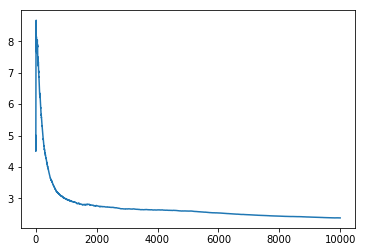

In [2]:
import matplotlib.pyplot as plt
plt.plot(store_lag[0])
plt.show()

In [3]:
np.savetxt('GWJAL_penalty',store_penalty)
np.savetxt('GWJAL_Lag',store_lag)